## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'approx1e5-agriVision-fourier-green' # Dataset Format: size-name-transform-channel

In [2]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
path_dict = dict(zip(['size', 'name', 'transform', 'channel'], DATA_NAME.split("-")))
CWD = os.path.join(ROOT_DIR, os.path.join("results", "case-studies", path_dict['name'], path_dict['transform'], path_dict['size'], path_dict['channel']))
assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "groupCDFs")).mkdir(exist_ok=True)

GROUP = 'layer' if path_dict['transform'] == 'wavelet' else ('band' if path_dict['transform'] == 'fourier' else 'error')
RERUN = False
CWD

'c:\\Users\\riyap\\OneDrive\\Documents\\GitHub\\hierarchical-bayesian-model-validation\\results\\case-studies\\agriVision\\fourier\\approx1e5\\green'

In [3]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [4]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}-size.pickle'))

if path_dict['transform'] == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif path_dict['transform'] == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = [os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)]
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[1:]:
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::1000] for g in GROUPS} # For quick testing purposes
group_total_samples

{2: 45000,
 3: 72000,
 4: 63000,
 5: 117000,
 6: 126000,
 7: 171000,
 8: 189000,
 9: 297000,
 10: 396000,
 11: 495000,
 12: 648000,
 13: 882000,
 14: 1134000,
 15: 1539000,
 16: 1953000,
 17: 2574000,
 18: 3456000,
 19: 4563000,
 20: 5967000,
 21: 8010000,
 22: 10395000,
 23: 13887000,
 24: 18297000,
 25: 24057000,
 26: 31968000,
 27: 42183000,
 28: 55764000,
 29: 73701000,
 30: 97326000,
 31: 108342000,
 32: 59634000,
 33: 21420000}

c:\Users\riyap\OneDrive\Documents\GitHub\hierarchical-bayesian-model-validation\utilities\testing.py:582: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
c:\Users\riyap\OneDrive\Documents\GitHub\hierarchical-bayesian-model-validation\utilities\testing.py:590: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
c:\Users\riyap\OneDrive\Documents\GitHub\hierarchical-bayesian-model-validation\utilities\testing.py:590: RuntimeWarning: overflow encountered in scalar power
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
c:\Users\riyap\OneDrive\Documents\GitHub\hierarchical-bayesian-model-validation\utilities\testing.py:590: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = scale*3*scipy.special.gamma(beta

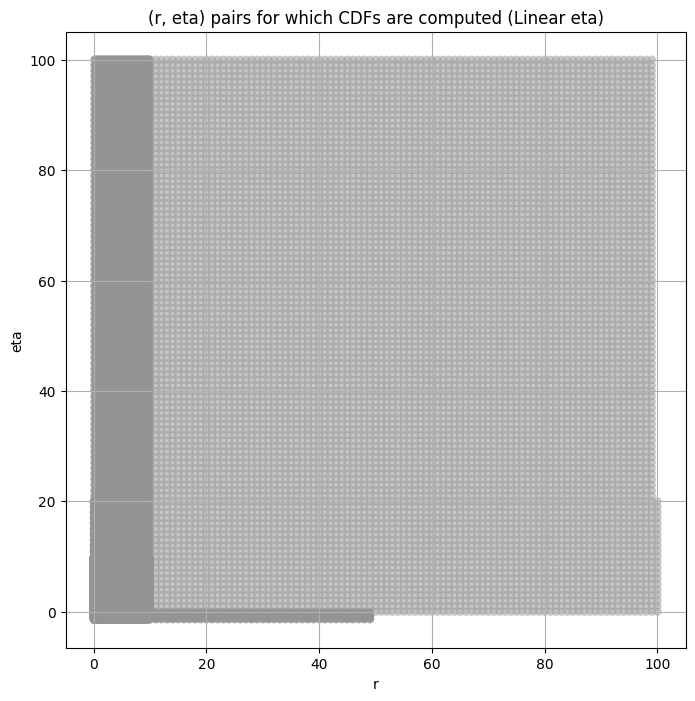

(r,eta),cdf     r  eta  \
0  ((0.02, -1.4), <scipy.interpolate._fitpack2.In...  0.02 -1.4   
1  ((0.02, -1.3), <scipy.interpolate._fitpack2.In...  0.02 -1.3   
2  ((0.02, -1.2), <scipy.interpolate._fitpack2.In...  0.02 -1.2   
3  ((0.02, -1.1), <scipy.interpolate._fitpack2.In...  0.02 -1.1   
4  ((0.02, -1.0), <scipy.interpolate._fitpack2.In...  0.02 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  9.618487e+69   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.821735e+74   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.455488e+78   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.406735e+81   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  5.331443e+83   

       kurtosis  
0  1.391529e+25  
1  8.172634e+21  
2  4.131785e+19  
3  6.947275e+17  
4  2.562075e+16

In [5]:
#warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
coarse_cdf_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 0) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 0) == all_cdfs_df['eta'])]
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [6]:
n_bootstrap = int(1e5)
bootstrap_size = int(1e4)
ci = 0.99

In [7]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists():
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


100%|██████████| 100000/100000 [01:16<00:00, 1311.63it/s]


Band 5


100%|██████████| 100000/100000 [01:13<00:00, 1356.68it/s]


Band 8


100%|██████████| 100000/100000 [01:10<00:00, 1415.58it/s]


Band 11


100%|██████████| 100000/100000 [01:16<00:00, 1308.03it/s]


Band 14


100%|██████████| 100000/100000 [01:14<00:00, 1339.82it/s]


Band 17


100%|██████████| 100000/100000 [01:15<00:00, 1316.24it/s]


Band 20


100%|██████████| 100000/100000 [01:15<00:00, 1330.68it/s]


Band 23


100%|██████████| 100000/100000 [01:13<00:00, 1366.94it/s]


Band 26


100%|██████████| 100000/100000 [01:13<00:00, 1359.92it/s]


Band 29


100%|██████████| 100000/100000 [01:08<00:00, 1460.85it/s]


Band 32


100%|██████████| 100000/100000 [01:06<00:00, 1497.49it/s]


obs_var     var_lower     var_upper     obs_kurt  kurt_lower  \
band                                                                      
2     2.994335e+08  1.760216e+08  5.098672e+08    473.18463   99.004295   
5     1.987477e+08  9.572140e+07  7.059408e+08   2945.43360  101.462210   
8     6.328288e+07  3.516824e+07  1.386849e+08    918.95044   93.302230   
11    3.658088e+07  1.481853e+07  1.571449e+08   6517.12160   80.002920   
14    1.184948e+07  6.202577e+06  3.326602e+07   1856.47970   73.761430   
17    7.712681e+06  2.964767e+06  4.547243e+07   9698.96400   65.262900   
20    4.424362e+06  1.713362e+06  2.342466e+07   8663.62000   69.641340   
23    1.867623e+06  6.317018e+05  1.241803e+07  16824.38000   62.361816   
26    1.038924e+06  1.671769e+05  1.046601e+07  32372.20000   72.455315   
29    1.627844e+05  2.092050e+04  1.356969e+06  37523.43800   88.508550   
32    4.012389e+03  2.159656e+03  1.135524e+04   1880.42440   83.458115   

      kurt_upper  total_samples  
band                             
2      1019.8701        45000.0  
5      5367.8350       117000.0  
8      2766.5867       189000.0  
11     6412.9240       495000.0  
14     4089.5234      1134000.0  
17     7472.8240      2574000.0  
20     7133.9710      5967000.0  
23     8305.8750     13887000.0  
26     9320.1260     31968000.0  
29     9488.2370     73701000.0  
32     4042.0374     59634000.0

## Initial Grid Search and Hypothesis Test Plots

####
Band  2


100%|██████████| 55966/55966 [03:21<00:00, 277.87it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 45000, Without approximation : 45000.0


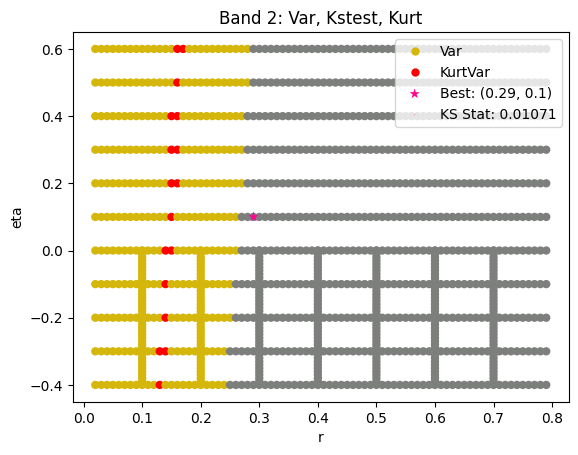

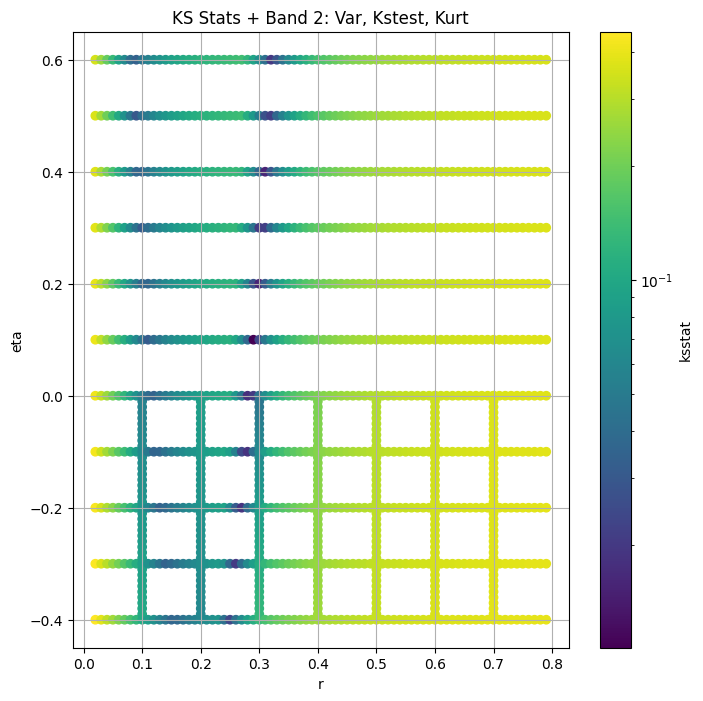

####
Band  5


100%|██████████| 55966/55966 [07:32<00:00, 123.65it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 117000.0


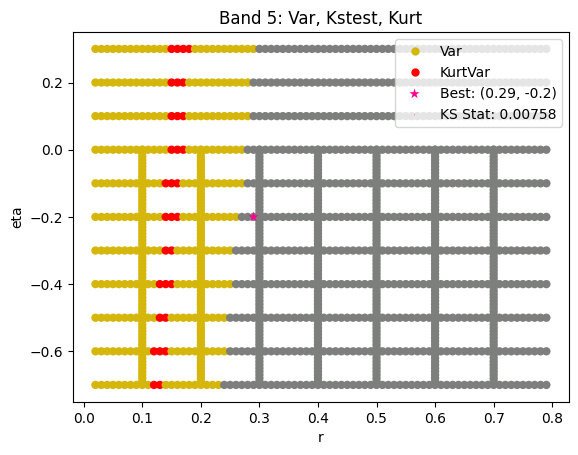

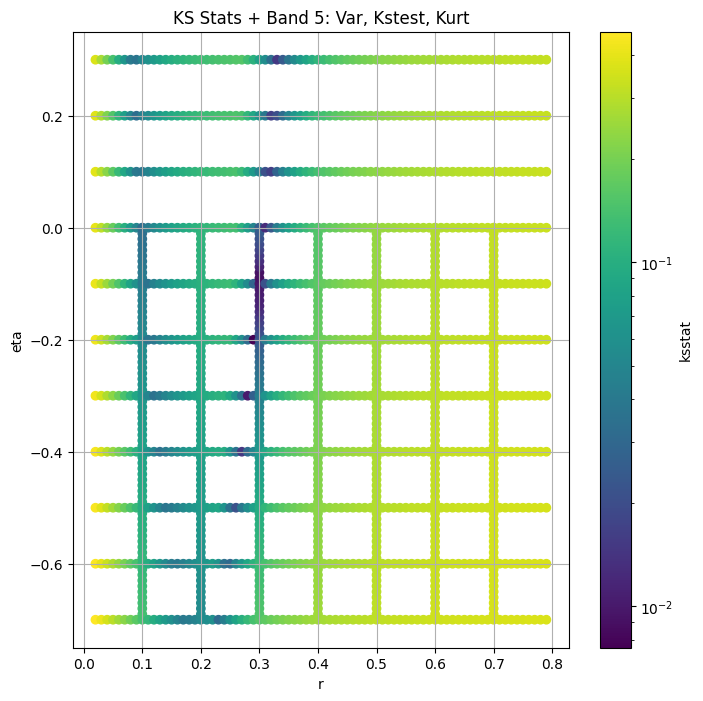

####
Band  8


100%|██████████| 55966/55966 [07:41<00:00, 121.15it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 189000.0


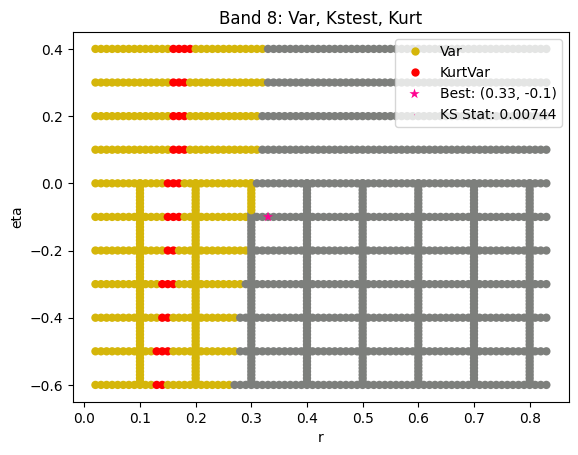

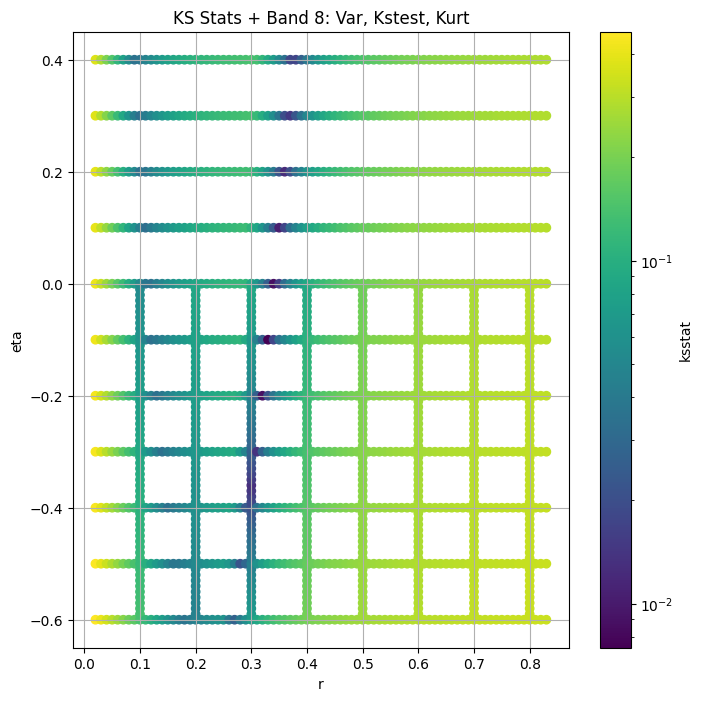

####
Band  11


100%|██████████| 55966/55966 [07:43<00:00, 120.87it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 495000.0


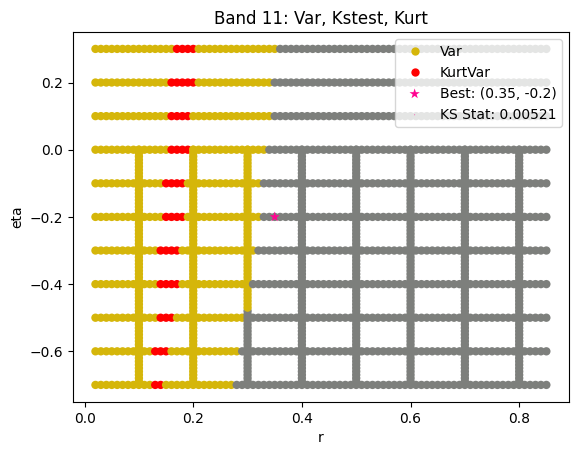

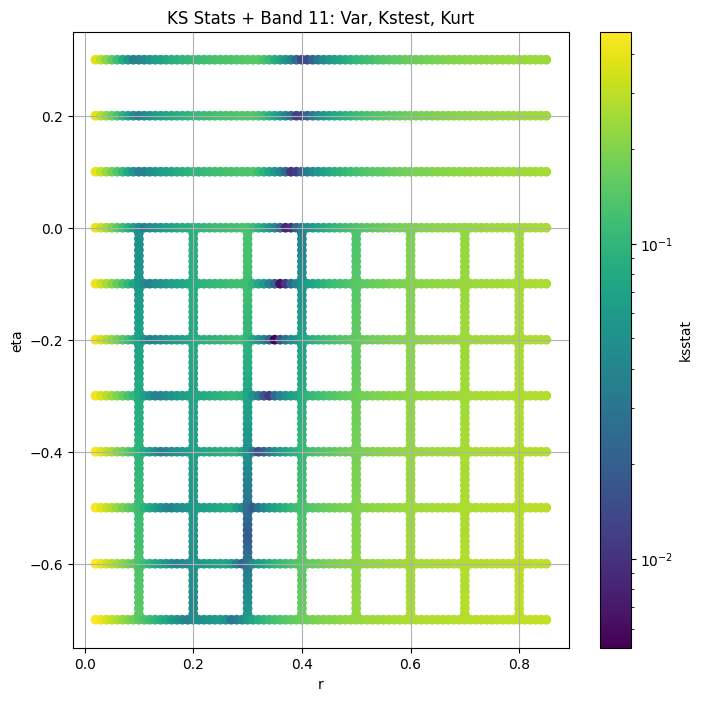

####
Band  14


100%|██████████| 55966/55966 [07:38<00:00, 121.94it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 1134000.0


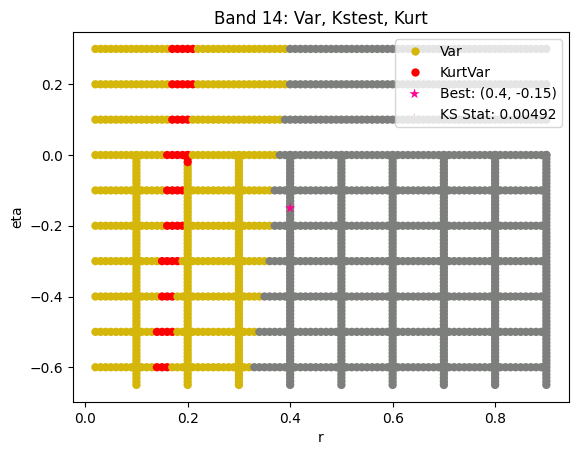

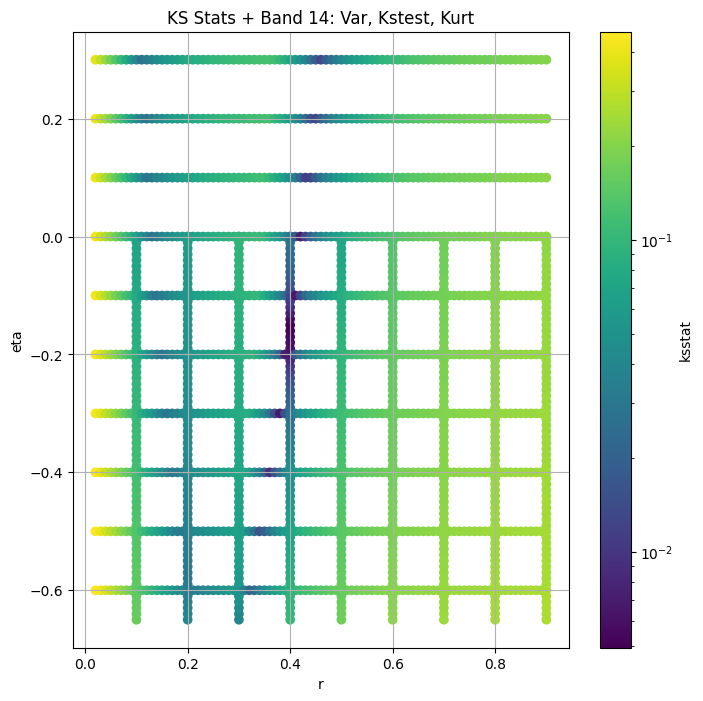

####
Band  17


100%|██████████| 55966/55966 [07:32<00:00, 123.62it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 2574000.0


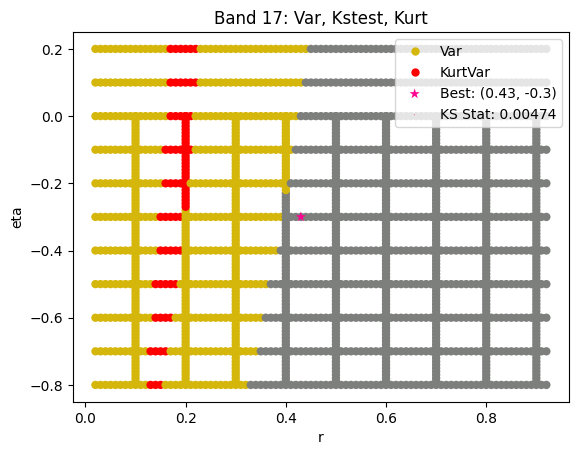

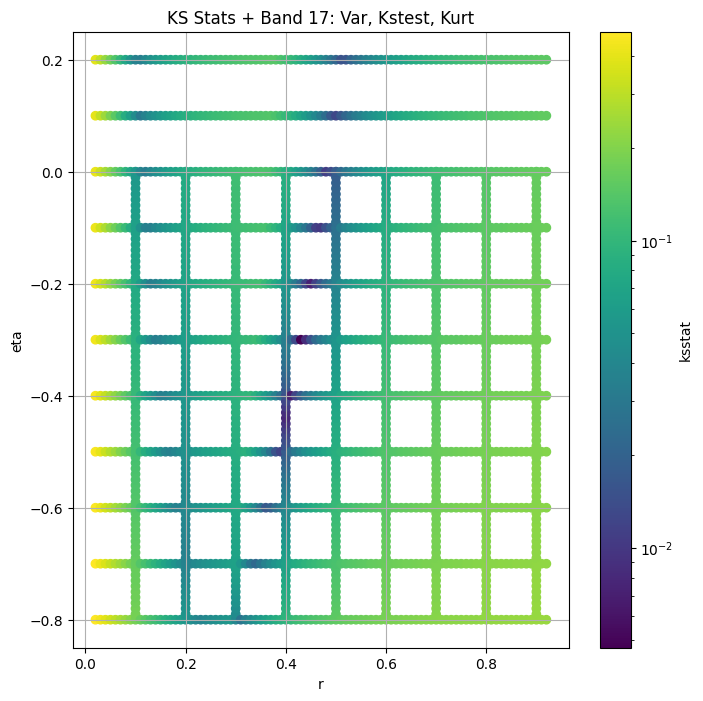

####
Band  20


100%|██████████| 55966/55966 [07:28<00:00, 124.72it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 5967000.0


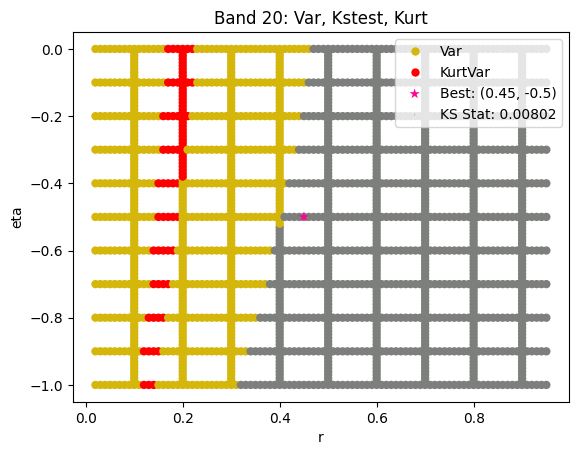

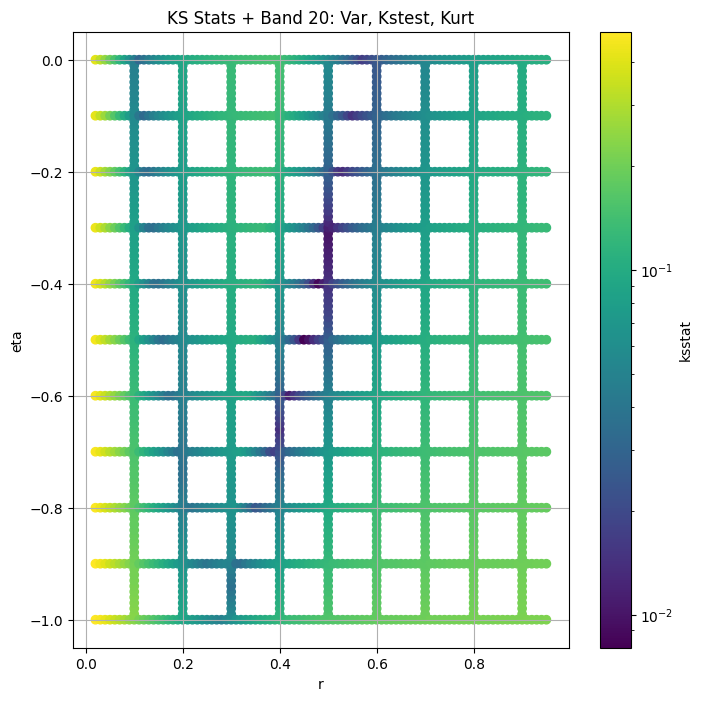

####
Band  23


100%|██████████| 55966/55966 [07:37<00:00, 122.44it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 13887000.0


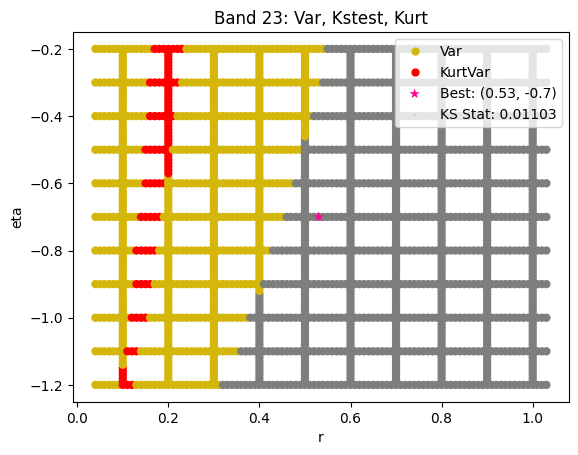

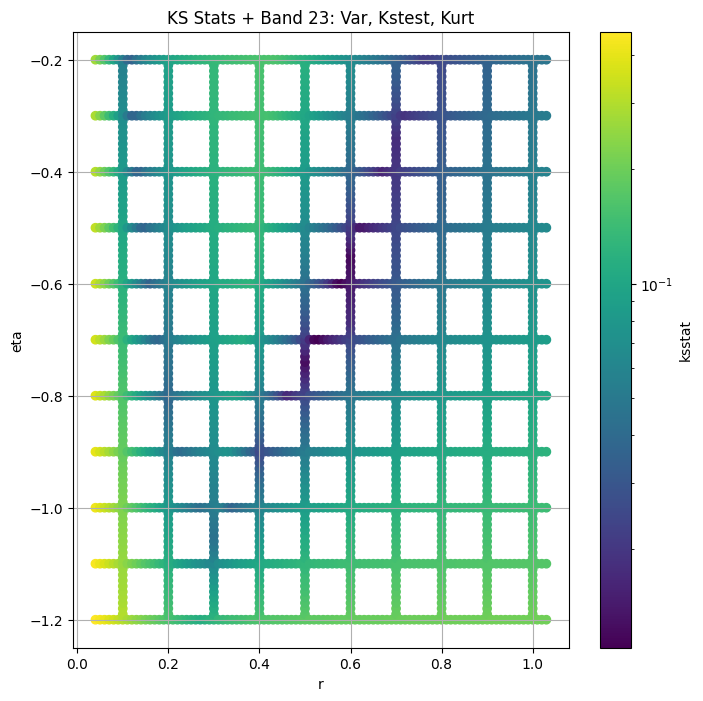

####
Band  26


100%|██████████| 55966/55966 [07:36<00:00, 122.55it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 31968000.0


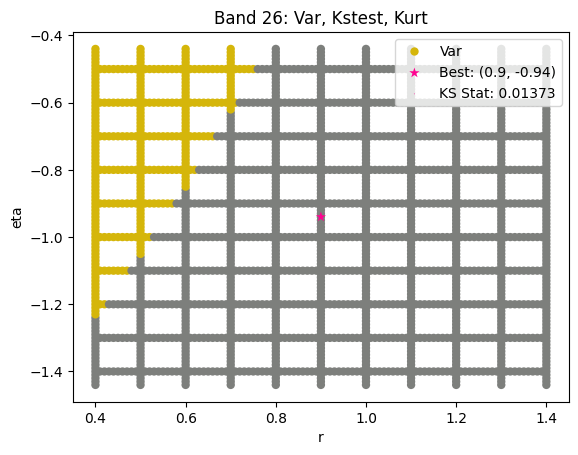

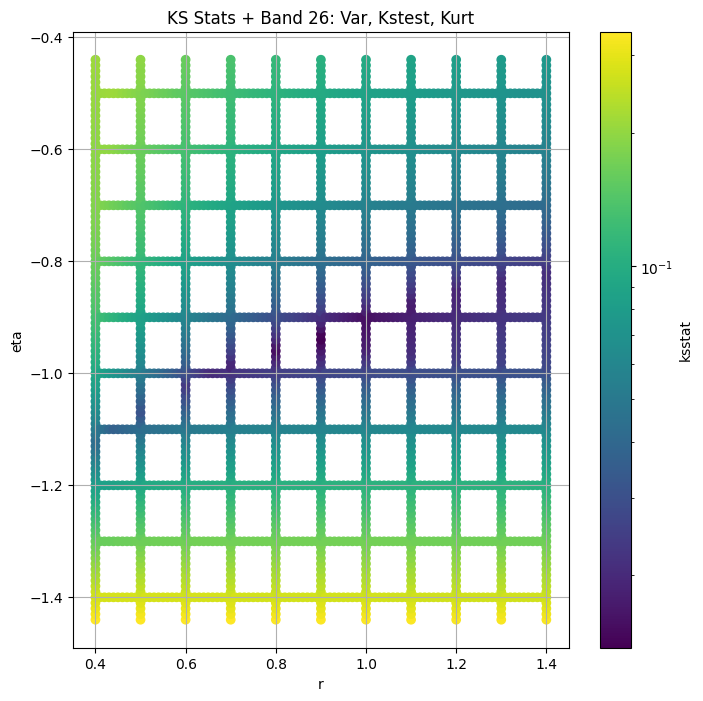

####
Band  29


100%|██████████| 55966/55966 [07:26<00:00, 125.35it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 73701000.0


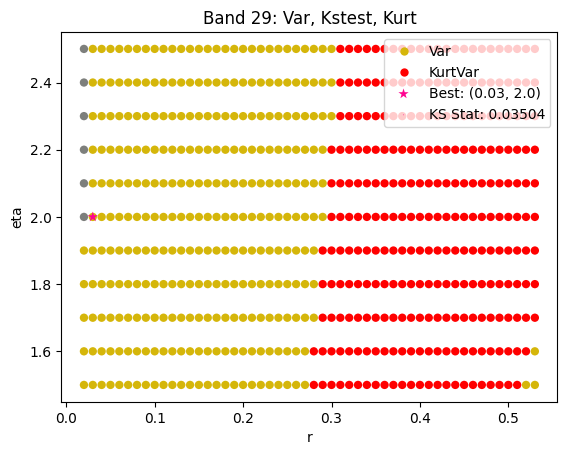

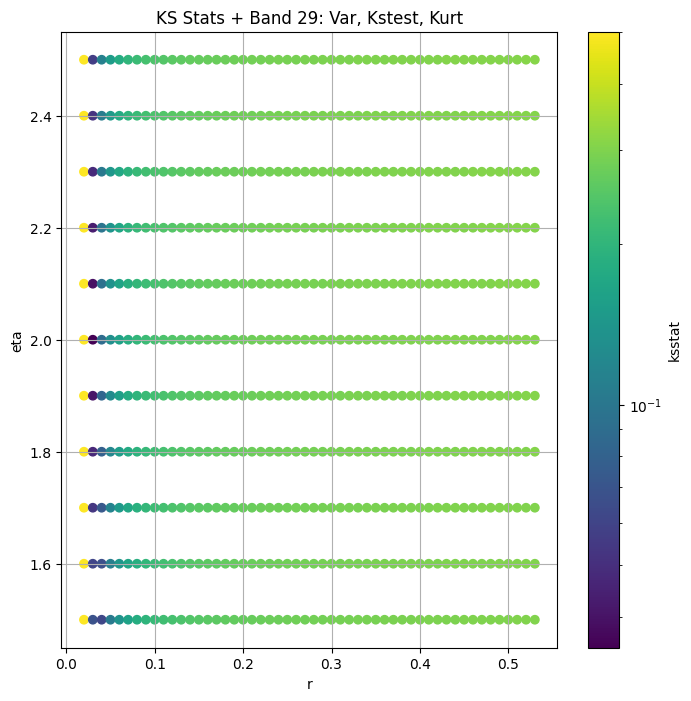

####
Band  32


100%|██████████| 55966/55966 [07:18<00:00, 127.70it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 59634000.0


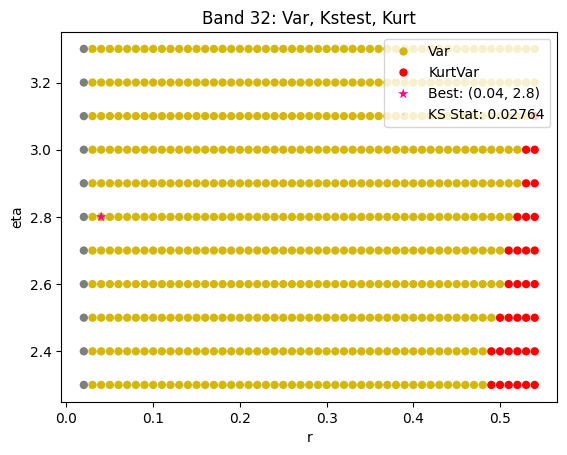

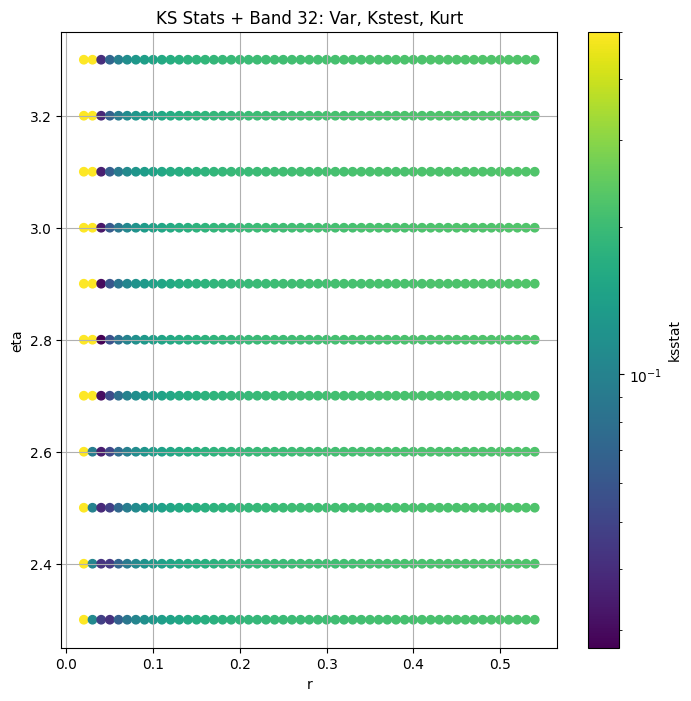

obs_var     var_lower     var_upper     obs_kurt  kurt_lower  \
band                                                                      
2     2.994335e+08  1.760216e+08  5.098672e+08    473.18463   99.004295   
5     1.987477e+08  9.572140e+07  7.059408e+08   2945.43360  101.462210   
8     6.328288e+07  3.516824e+07  1.386849e+08    918.95044   93.302230   
11    3.658088e+07  1.481853e+07  1.571449e+08   6517.12160   80.002920   
14    1.184948e+07  6.202577e+06  3.326602e+07   1856.47970   73.761430   
17    7.712681e+06  2.964767e+06  4.547243e+07   9698.96400   65.262900   
20    4.424362e+06  1.713362e+06  2.342466e+07   8663.62000   69.641340   
23    1.867623e+06  6.317018e+05  1.241803e+07  16824.38000   62.361816   
26    1.038924e+06  1.671769e+05  1.046601e+07  32372.20000   72.455315   
29    1.627844e+05  2.092050e+04  1.356969e+06  37523.43800   88.508550   
32    4.012389e+03  2.159656e+03  1.135524e+04   1880.42440   83.458115   

      kurt_upper  total_samples  initial_r  initial_eta  initial_scale  \
band                                                                     
2      1019.8701        45000.0       0.29         0.10   1.000000e+05   
5      5367.8350       117000.0       0.29        -0.20   1.000000e+05   
8      2766.5867       189000.0       0.33        -0.10   1.000000e+05   
11     6412.9240       495000.0       0.35        -0.20   1.000000e+05   
14     4089.5234      1134000.0       0.40        -0.15   1.000000e+05   
17     7472.8240      2574000.0       0.43        -0.30   1.000000e+05   
20     7133.9710      5967000.0       0.45        -0.50   1.000000e+05   
23     8305.8750     13887000.0       0.53        -0.70   1.000000e+05   
26     9320.1260     31968000.0       0.90        -0.94   1.000000e+05   
29     9488.2370     73701000.0       0.03         2.00   2.970571e-66   
32     4042.0374     59634000.0       0.04         2.80   4.886955e-49   

      kstest_stat_initial  kstest_stat_cutoff_0.05  
band                                                
2                0.010707                 0.006398  
5                0.007578                 0.003969  
8                0.007435                 0.003123  
11               0.005214                 0.001930  
14               0.004919                 0.001275  
17               0.004736                 0.000846  
20               0.008021                 0.000556  
23               0.011029                 0.000364  
26               0.013731                 0.000240  
29               0.035039                 0.000158  
32               0.027643                 0.000176

In [8]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    group_cdf_df_dict = dict()
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS):
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdf_df = all_cdfs_df.copy()
        
        group_cdf_df['scale'] = np.clip(master_df.loc[group,'obs_var'] / group_cdf_df['variance'], 0, 1e5)
        ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdf_df['scale'])
        initial_scale = group_cdf_df.loc[(group_cdf_df["r"] ==  initial_param[0]) & (group_cdf_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
        master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
        master_df.loc[group, 'initial_scale'] = initial_scale
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        master_df.loc[group, 'kstest_stat_initial'] = min_stat
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        group_cdf_df['variance'] = group_cdf_df['variance'] * group_cdf_df['scale']
        group_cdf_df['kurtosis'] = group_cdf_df['kurtosis'] * group_cdf_df['scale']

        group_cdf_df = add_tests_to_df(cdfs_df = group_cdf_df, group = group, var_kurt_df = master_df, ksstats = ksstats)
        group_cdf_df_dict[group] = group_cdf_df
        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdf_df_dict[group], cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])}", 
                            target_var = None,
                            best_param = initial_param,
                            best_ksstat=min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=300)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdf_df_dict[group], var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdf_df_dict[group], kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_combo.csv"))

master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
master_df

### Search over $\eta=0$

In [9]:
master_df_eta0_path = Path(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

if RERUN or not master_df_eta0_path.exists():
    best_params_eta0 = []
    for i, group in enumerate(GROUPS):
        if master_df.loc[group, 'initial_eta'] != 0:
            sample = group_data_map[group]
            group_cdf = all_cdfs_df[all_cdfs_df['eta'] == 0]
            cdfs_dict = {i[0]:i[1] for i in group_cdf['(r,eta),cdf']}
            ksstats, best_param_eta0, kstest_stat_eta0 = gridsearch(sample, cdfs_dict, debug=True, scales=group_cdf_df['scale'])
            best_scale_eta0 = group_cdf_df.loc[(group_cdf_df["r"] ==  best_param_eta0[0]) & (group_cdf_df["eta"] ==  best_param_eta0[1])]["scale"].iloc[0]
            master_df.loc[group, 'best_r_eta0'] = best_param_eta0[0]
            master_df.loc[group, 'best_scale_eta0'] = best_scale_eta0
            master_df.loc[group, 'kstest_stat_eta0'] = kstest_stat_eta0
        else:
            master_df.loc[group, 'kstest_stat_eta0'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r_eta0'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_scale_eta0'] = master_df.loc[group, 'initial_scale']
    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

master_df = pd.read_csv(master_df_eta0_path, index_col=GROUP)
master_df

100%|██████████| 369/369 [00:01<00:00, 289.33it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:03<00:00, 122.12it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:02<00:00, 124.52it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:02<00:00, 125.42it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:03<00:00, 121.83it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:02<00:00, 124.61it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:02<00:00, 129.47it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:03<00:00, 122.66it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:03<00:00, 121.24it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:02<00:00, 124.69it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:03<00:00, 121.18it/s]

Finding Minimum after computing 369 CDFs


obs_var     var_lower     var_upper     obs_kurt  kurt_lower  \
band                                                                      
2     2.994335e+08  1.760216e+08  5.098672e+08    473.18463   99.004295   
5     1.987477e+08  9.572140e+07  7.059408e+08   2945.43360  101.462210   
8     6.328288e+07  3.516824e+07  1.386849e+08    918.95044   93.302230   
11    3.658088e+07  1.481853e+07  1.571449e+08   6517.12160   80.002920   
14    1.184948e+07  6.202577e+06  3.326602e+07   1856.47970   73.761430   
17    7.712681e+06  2.964767e+06  4.547243e+07   9698.96400   65.262900   
20    4.424362e+06  1.713362e+06  2.342466e+07   8663.62000   69.641340   
23    1.867623e+06  6.317018e+05  1.241803e+07  16824.38000   62.361816   
26    1.038924e+06  1.671769e+05  1.046601e+07  32372.20000   72.455315   
29    1.627844e+05  2.092050e+04  1.356969e+06  37523.43800   88.508550   
32    4.012389e+03  2.159656e+03  1.135524e+04   1880.42440   83.458115   

      kurt_upper  total_samples  initial_r  initial_eta  initial_scale  \
band                                                                     
2      1019.8701        45000.0       0.29         0.10   1.000000e+05   
5      5367.8350       117000.0       0.29        -0.20   1.000000e+05   
8      2766.5867       189000.0       0.33        -0.10   1.000000e+05   
11     6412.9240       495000.0       0.35        -0.20   1.000000e+05   
14     4089.5234      1134000.0       0.40        -0.15   1.000000e+05   
17     7472.8240      2574000.0       0.43        -0.30   1.000000e+05   
20     7133.9710      5967000.0       0.45        -0.50   1.000000e+05   
23     8305.8750     13887000.0       0.53        -0.70   1.000000e+05   
26     9320.1260     31968000.0       0.90        -0.94   1.000000e+05   
29     9488.2370     73701000.0       0.03         2.00   2.970571e-66   
32     4042.0374     59634000.0       0.04         2.80   4.886955e-49   

      kstest_stat_initial  kstest_stat_cutoff_0.05  best_r_eta0  \
band                                                              
2                0.010707                 0.006398         0.36   
5                0.007578                 0.003969         0.36   
8                0.007435                 0.003123         0.36   
11               0.005214                 0.001930         0.37   
14               0.004919                 0.001275         0.42   
17               0.004736                 0.000846         0.48   
20               0.008021                 0.000556         0.57   
23               0.011029                 0.000364         0.86   
26               0.013731                 0.000240         6.00   
29               0.035039                 0.000158         6.00   
32               0.027643                 0.000176         5.90   

      best_scale_eta0  kstest_stat_eta0  
band                                     
2           45.910364          0.160696  
5           45.910364          0.095457  
8           45.910364          0.032307  
11          56.199247          0.008155  
14         130.489745          0.006948  
17         273.722355          0.010941  
20         590.821649          0.016725  
23        2002.754061          0.025360  
26        6837.587389          0.087093  
29        6837.587389          0.258260  
32        6833.046126          0.361579

## Optimization

In [10]:
def simple_add_cdfs(r_range, eta_range, dir, folder_name = '', n_samples = 500, tail_bound = 0.01, tail_percent = 0.1, enforce_assert=True, return_assert = False, debug=False):

    if folder_name == '':
        folder_name = f'r{round_to_sigfigs(min(r_range))}to{round_to_sigfigs(max(r_range))}_eta{round_to_sigfigs(min(eta_range))}to{round_to_sigfigs(max(eta_range))}'

    FOLDER_PATH = os.path.join(dir, folder_name)

    if os.path.isdir(FOLDER_PATH):
        cdfs_completed = combine_pickles(FOLDER_PATH)
        if debug:
            print("CDFs completed:", len(cdfs_completed))
    else:
        Path(os.path.join(os.getcwd(), FOLDER_PATH)).mkdir()
        cdfs_completed = dict()

    n = len(r_range)*len(eta_range)
    finished = len(cdfs_completed)
    cnt = len(cdfs_completed)
    for r in r_range:
        r_cdf = dict()
        r = round_to_sigfigs(r)
        for eta in eta_range:
            eta = round_to_sigfigs(eta)
            if ((r, eta) in cdfs_completed) and cdfs_completed[(r, eta)]:
                continue
            cnt += 1
            if debug:
                print(f'{(r, eta)}, {cnt} of {n + finished}')
            if cnt % 50 == 0:
                print(f'{(r, eta)}, {cnt} of {n + finished}')

            computed_cdf = compute_prior_cdf(r = r, eta = eta, method = 'gamma_cdf', n_samples = n_samples, tail_percent = tail_percent, tail_bound = tail_bound, 
                                             enforce_assert=enforce_assert, return_assert=return_assert, debug=debug)
            r_cdf[(r, eta)] = computed_cdf
        if r_cdf:
            sorted_r_cdf = [i[1] for i in sorted(r_cdf)]
            min_eta, max_eta = round_to_sigfigs(min(sorted_r_cdf), 6), round_to_sigfigs(max(sorted_r_cdf), 6)
            pkl_path = os.path.join(FOLDER_PATH, f'r{r}_eta{min_eta}to{max_eta}.pickle')
            pd.to_pickle(r_cdf, pkl_path)
        else:
            if debug:
                print(f"Skipped {r} entirely")

    if debug:
        print(f'You can find the CDFs here: {os.path.join(os.getcwd(), FOLDER_PATH)}')

Band 2
(0.282, 0.09), 50 of 420
(0.284, 0.19), 100 of 420
(0.287, 0.09), 150 of 420
(0.289, 0.19), 200 of 420
(0.292, 0.09), 250 of 420
(0.294, 0.19), 300 of 420
(0.297, 0.09), 350 of 420
(0.299, 0.19), 400 of 420


100%|██████████| 420/420 [00:01<00:00, 295.05it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 2 best parameters: ((0.283, 0), 0.009509945930714192)


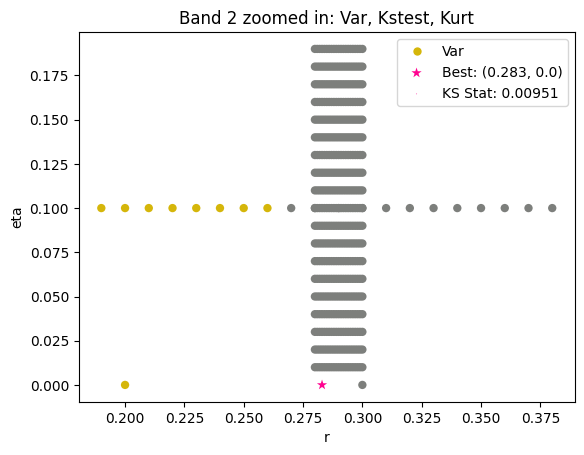

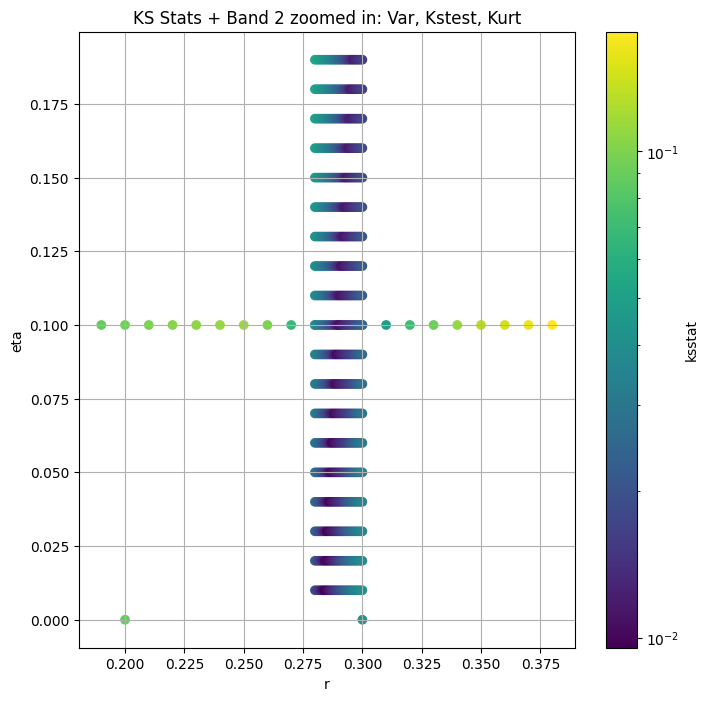

Band 5
(0.282, -0.23), 50 of 441
(0.284, -0.15), 100 of 441
(0.287, -0.28), 150 of 441
(0.289, -0.2), 200 of 441
(0.291, -0.12), 250 of 441
(0.294, -0.25), 300 of 441
(0.296, -0.17), 350 of 441
(0.299, -0.3), 400 of 441


100%|██████████| 441/441 [00:04<00:00, 109.99it/s]


Finding Minimum after computing 441 CDFs
Iter 1 band 5 best parameters: ((0.291, -0.19), 0.007303096903708062)


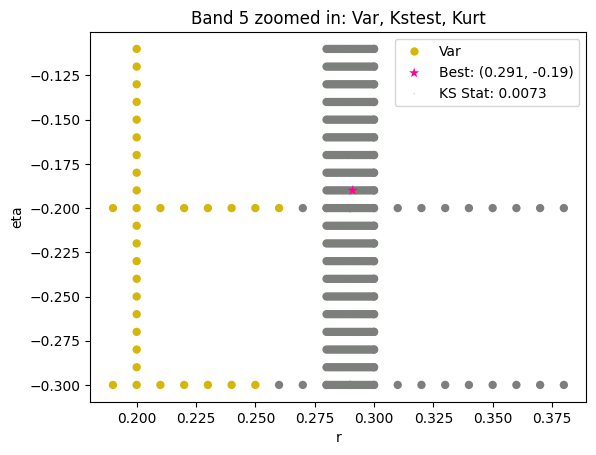

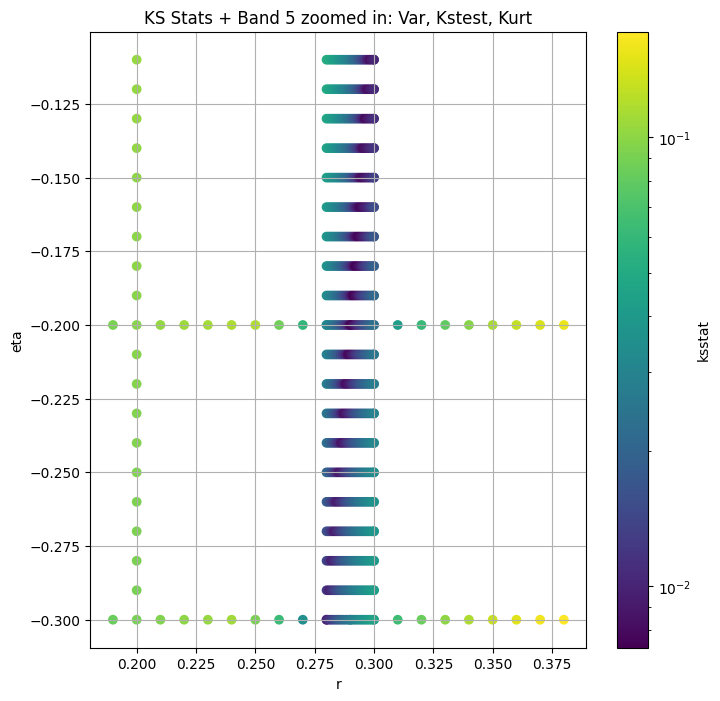

Band 8
(0.322, -0.11), 50 of 420
(0.324, -0.01), 100 of 420
(0.327, -0.11), 150 of 420
(0.329, -0.01), 200 of 420
(0.332, -0.11), 250 of 420
(0.334, -0.01), 300 of 420
(0.337, -0.11), 350 of 420
(0.339, -0.01), 400 of 420


100%|██████████| 420/420 [00:03<00:00, 112.38it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 8 best parameters: ((0.326, -0.14), 0.006993751130227266)


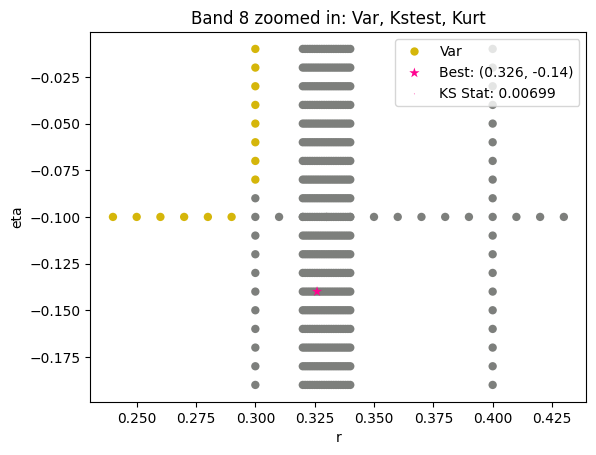

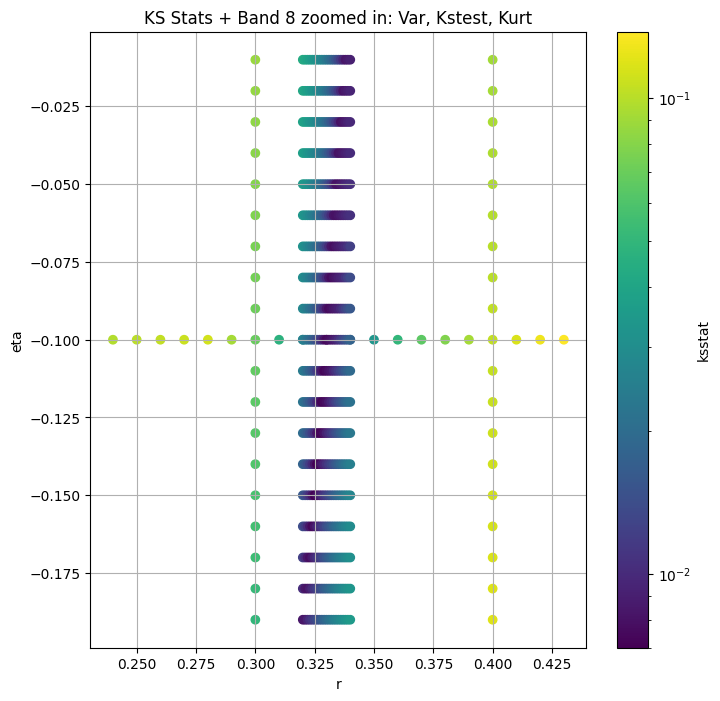

Band 11
(0.342, -0.23), 50 of 441
(0.344, -0.15), 100 of 441
(0.347, -0.28), 150 of 441
(0.349, -0.2), 200 of 441
(0.351, -0.12), 250 of 441
(0.354, -0.25), 300 of 441
(0.356, -0.17), 350 of 441
(0.359, -0.3), 400 of 441


100%|██████████| 441/441 [00:03<00:00, 111.98it/s]


Finding Minimum after computing 441 CDFs
Iter 1 band 11 best parameters: ((0.351, -0.19), 0.005168148184356514)


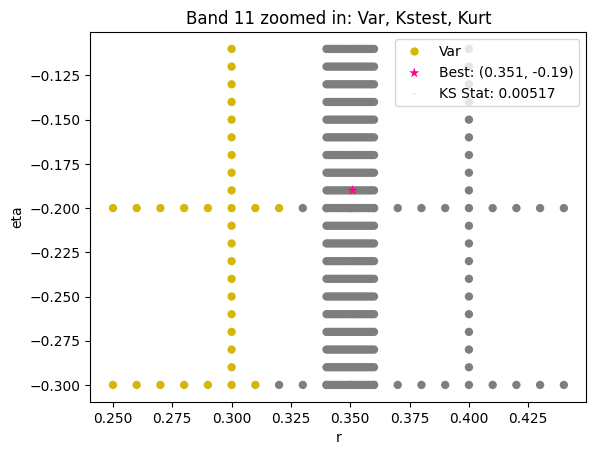

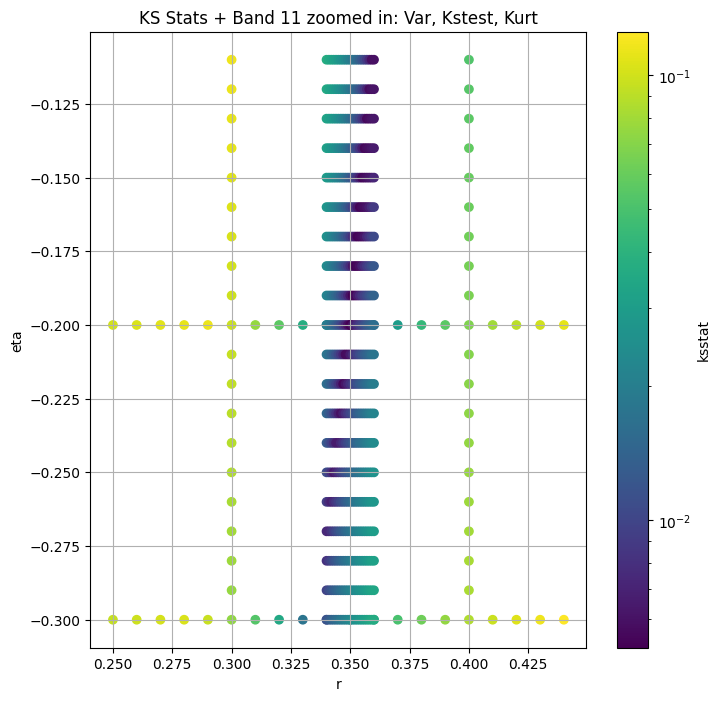

Band 14
(0.32, -0.153), 50 of 420
(0.34, -0.145), 100 of 420
(0.37, -0.158), 150 of 420
(0.39, -0.15), 200 of 420
(0.41, -0.142), 250 of 420
(0.44, -0.155), 300 of 420
(0.46, -0.147), 350 of 420
(0.49, -0.16), 400 of 420


100%|██████████| 420/420 [00:04<00:00, 101.30it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 14 best parameters: ((0.4, -0.145), 0.004819888552052098)


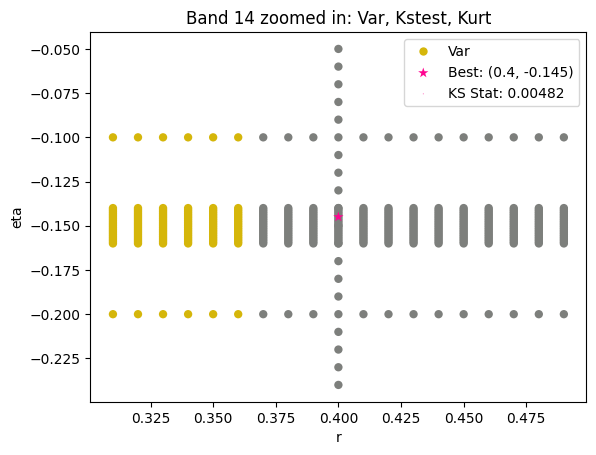

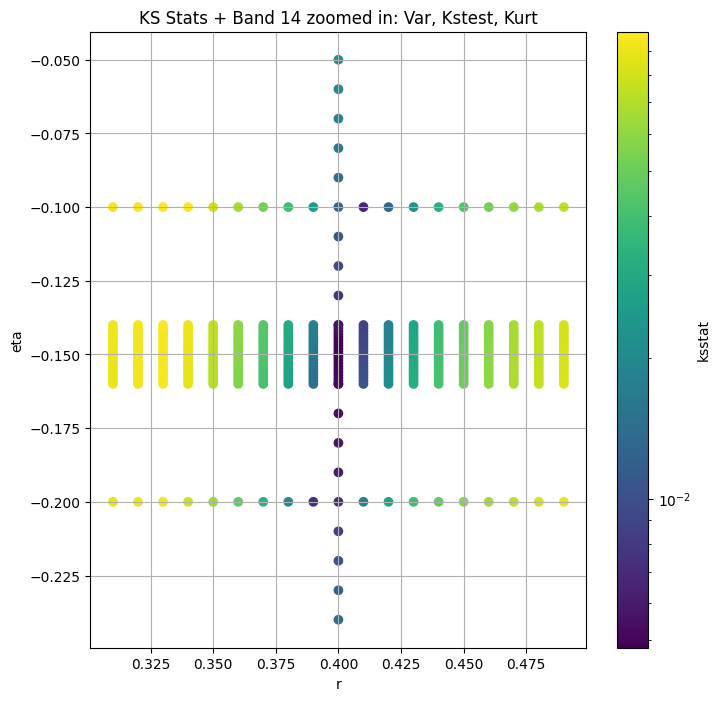

Band 17
(0.422, -0.33), 50 of 441
(0.424, -0.25), 100 of 441
(0.427, -0.38), 150 of 441
(0.429, -0.3), 200 of 441
(0.431, -0.22), 250 of 441
(0.434, -0.35), 300 of 441
(0.436, -0.27), 350 of 441
(0.439, -0.4), 400 of 441


100%|██████████| 441/441 [00:04<00:00, 101.47it/s]


Finding Minimum after computing 441 CDFs
Iter 1 band 17 best parameters: ((0.426, -0.32), 0.004303474327775007)


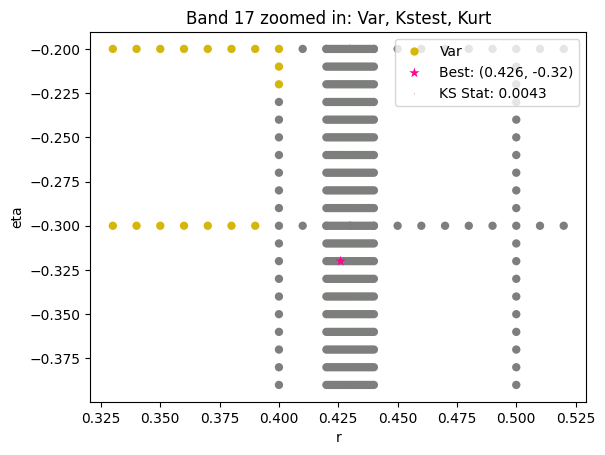

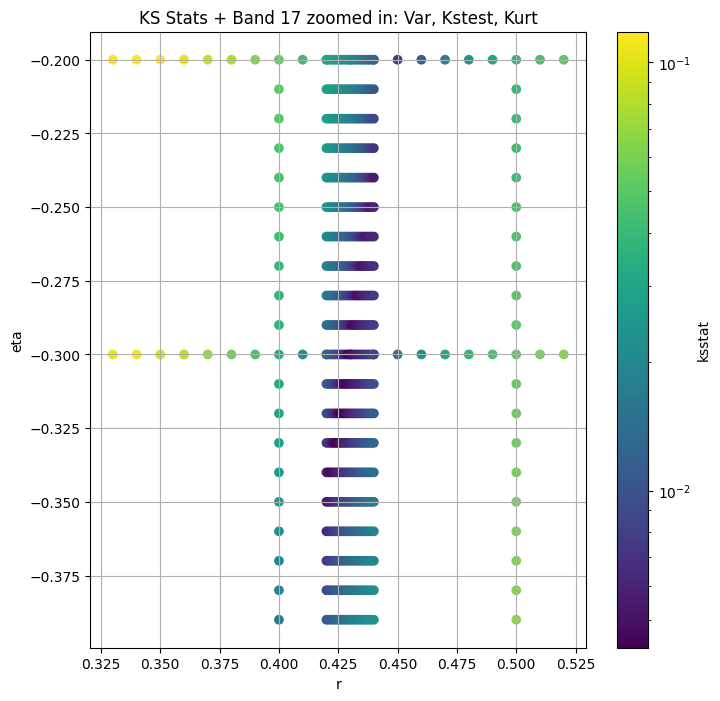

Band 20
(0.442, -0.51), 50 of 420
(0.444, -0.41), 100 of 420
(0.447, -0.51), 150 of 420
(0.449, -0.41), 200 of 420
(0.452, -0.51), 250 of 420
(0.454, -0.41), 300 of 420
(0.457, -0.51), 350 of 420
(0.459, -0.41), 400 of 420


100%|██████████| 420/420 [00:04<00:00, 100.68it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 20 best parameters: ((0.458, -0.48), 0.0064478980906602645)


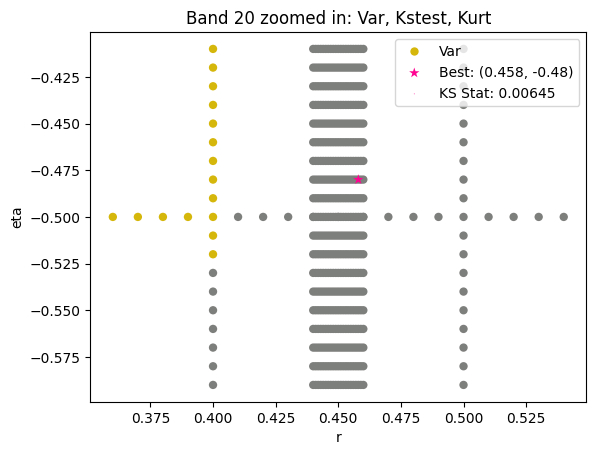

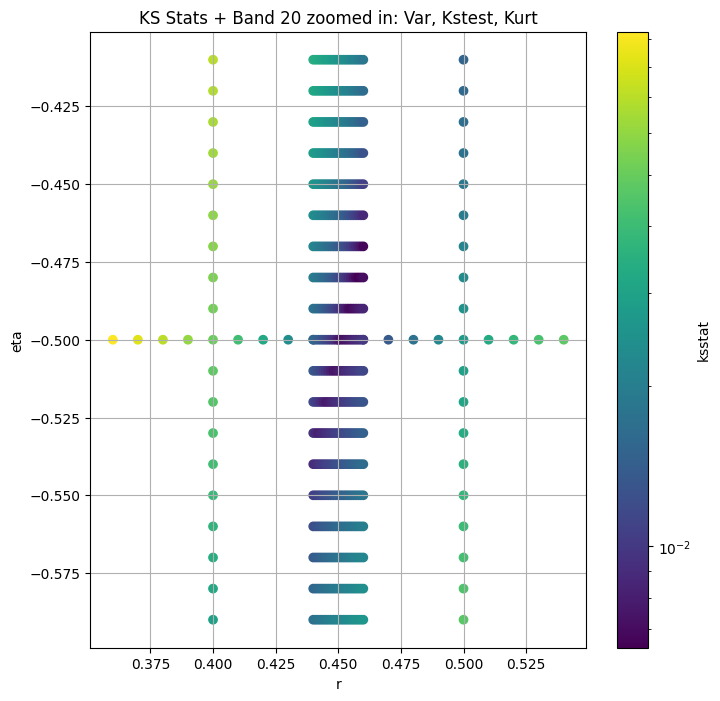

Band 23
(0.522, -0.71), 50 of 420
(0.524, -0.61), 100 of 420
(0.527, -0.71), 150 of 420
(0.529, -0.61), 200 of 420
(0.532, -0.71), 250 of 420
(0.534, -0.61), 300 of 420
(0.537, -0.71), 350 of 420
(0.539, -0.61), 400 of 420


100%|██████████| 420/420 [00:04<00:00, 102.91it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 23 best parameters: ((0.537, -0.68), 0.009117780890729787)


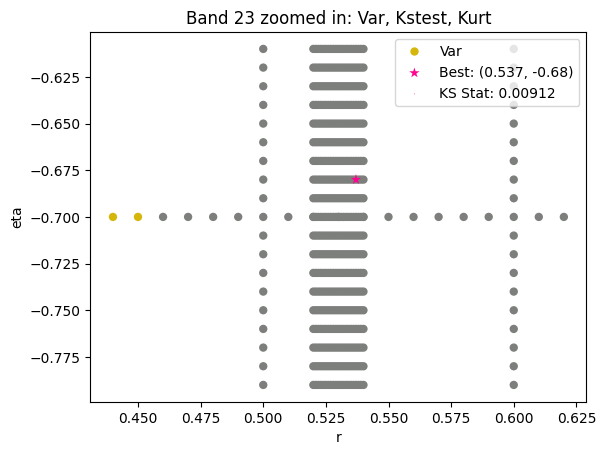

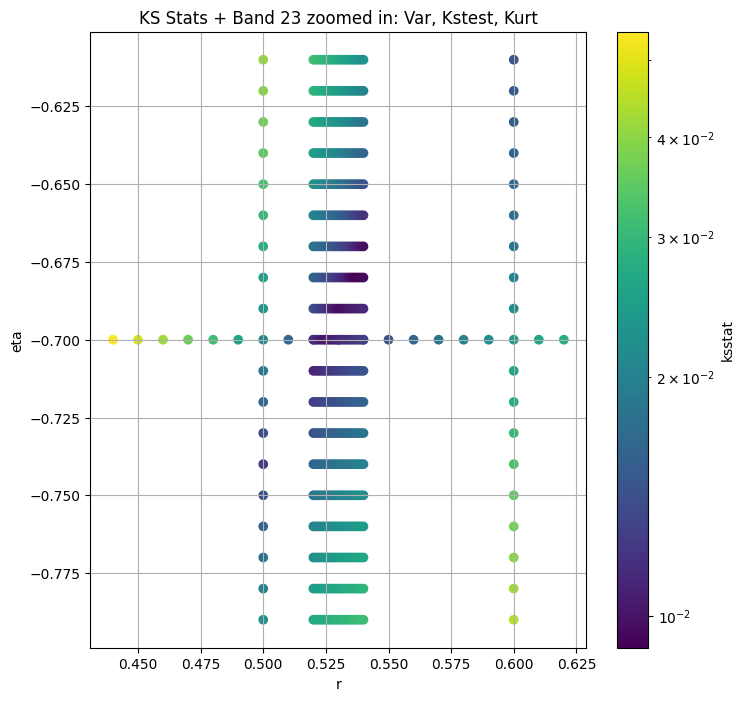

Band 26
(0.82, -0.943), 50 of 420
(0.84, -0.935), 100 of 420
(0.87, -0.948), 150 of 420
(0.89, -0.94), 200 of 420
(0.91, -0.932), 250 of 420
(0.94, -0.945), 300 of 420
(0.96, -0.937), 350 of 420
(0.99, -0.95), 400 of 420


100%|██████████| 420/420 [00:04<00:00, 93.56it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 26 best parameters: ((0.88, -0.94), 0.01315601637856545)


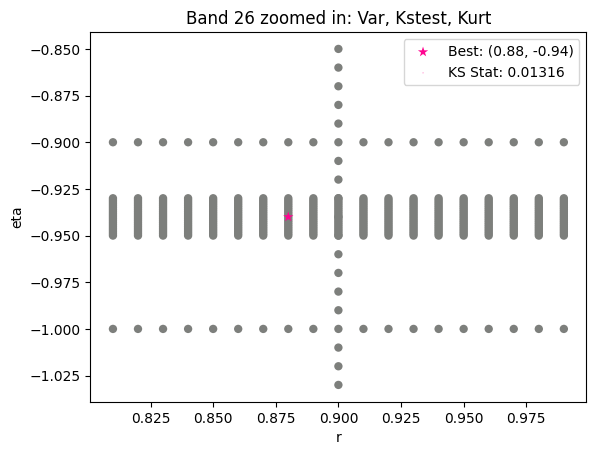

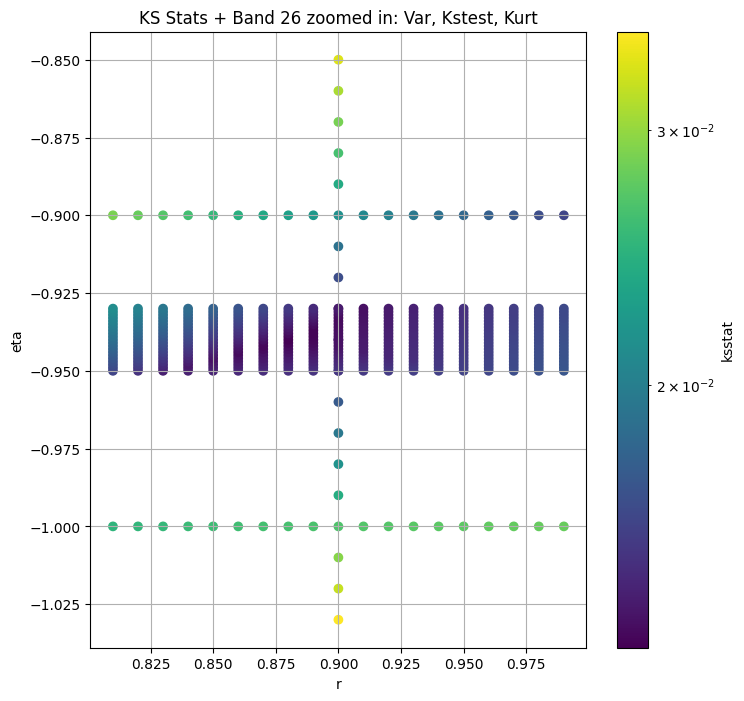

Band 29


c:\Users\riyap\OneDrive\Documents\GitHub\hierarchical-bayesian-model-validation\utilities\testing.py:76: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * special.gamma(beta + 1/r) / special.gamma(beta)


(0.022, 1.97), 50 of 441
(0.024, 2.05), 100 of 441
(0.027, 1.92), 150 of 441
(0.029, 2.0), 200 of 441
(0.031, 2.08), 250 of 441
(0.034, 1.95), 300 of 441
(0.036, 2.03), 350 of 441
(0.039, 1.9), 400 of 441


c:\Users\riyap\OneDrive\Documents\GitHub\hierarchical-bayesian-model-validation\utilities\testing.py:582: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
c:\Users\riyap\OneDrive\Documents\GitHub\hierarchical-bayesian-model-validation\utilities\testing.py:590: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
c:\Users\riyap\OneDrive\Documents\GitHub\hierarchical-bayesian-model-validation\utilities\testing.py:590: RuntimeWarning: overflow encountered in scalar power
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
c:\Users\riyap\OneDrive\Documents\GitHub\hierarchical-bayesian-model-validation\utilities\testing.py:590: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = scale*3*scipy.special.gamma(beta

Finding Minimum after computing 441 CDFs
Iter 1 band 29 best parameters: ((0.03, 2.0), 0.03503852199225865)


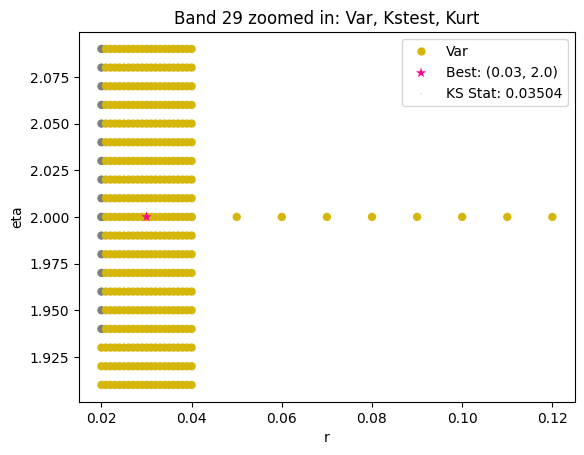

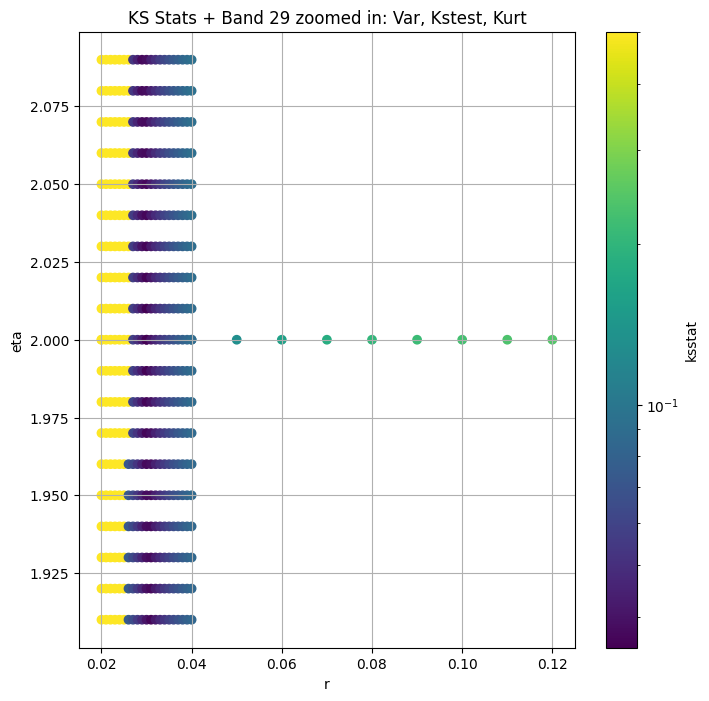

Band 32
(0.032, 2.77), 50 of 441
(0.034, 2.85), 100 of 441
(0.037, 2.72), 150 of 441
(0.039, 2.8), 200 of 441
(0.041, 2.88), 250 of 441
(0.044, 2.75), 300 of 441
(0.046, 2.83), 350 of 441
(0.049, 2.7), 400 of 441


c:\Users\riyap\OneDrive\Documents\GitHub\hierarchical-bayesian-model-validation\utilities\testing.py:590: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
c:\Users\riyap\OneDrive\Documents\GitHub\hierarchical-bayesian-model-validation\utilities\testing.py:590: RuntimeWarning: overflow encountered in scalar power
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
c:\Users\riyap\OneDrive\Documents\GitHub\hierarchical-bayesian-model-validation\utilities\testing.py:590: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
100%|██████████| 441/441 [00:04<00:00, 103.36it/s]


Finding Minimum after computing 441 CDFs
Iter 1 band 32 best parameters: ((0.04, 2.79), 0.027622464225693033)


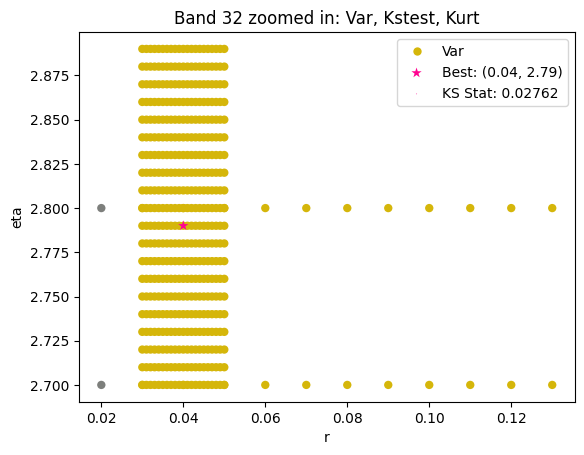

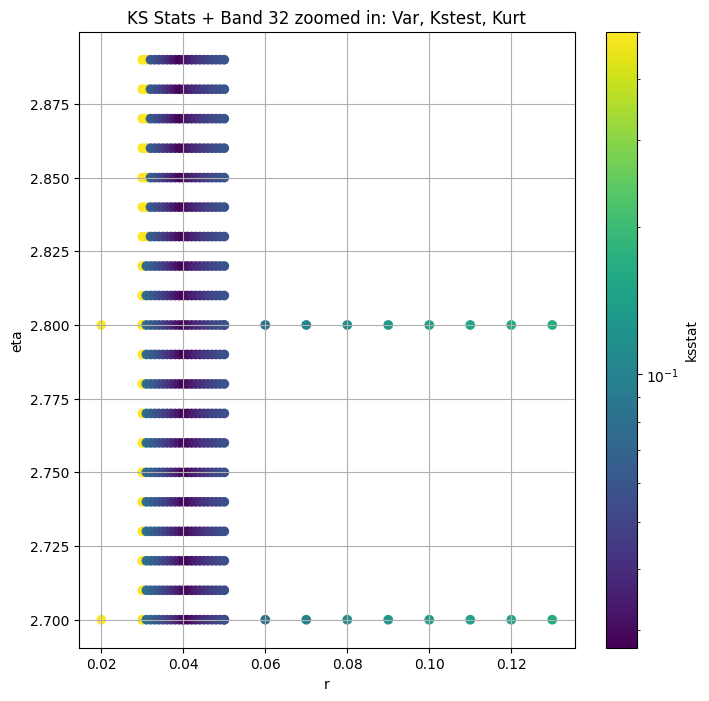

obs_var     var_lower     var_upper     obs_kurt  kurt_lower  \
band                                                                      
2     2.994335e+08  1.760216e+08  5.098672e+08    473.18463   99.004295   
5     1.987477e+08  9.572140e+07  7.059408e+08   2945.43360  101.462210   
8     6.328288e+07  3.516824e+07  1.386849e+08    918.95044   93.302230   
11    3.658088e+07  1.481853e+07  1.571449e+08   6517.12160   80.002920   
14    1.184948e+07  6.202577e+06  3.326602e+07   1856.47970   73.761430   
17    7.712681e+06  2.964767e+06  4.547243e+07   9698.96400   65.262900   
20    4.424362e+06  1.713362e+06  2.342466e+07   8663.62000   69.641340   
23    1.867623e+06  6.317018e+05  1.241803e+07  16824.38000   62.361816   
26    1.038924e+06  1.671769e+05  1.046601e+07  32372.20000   72.455315   
29    1.627844e+05  2.092050e+04  1.356969e+06  37523.43800   88.508550   
32    4.012389e+03  2.159656e+03  1.135524e+04   1880.42440   83.458115   

      kurt_upper  total_samples  initial_r  initial_eta  initial_scale  ...  \
band                                                                    ...   
2      1019.8701        45000.0       0.29         0.10   1.000000e+05  ...   
5      5367.8350       117000.0       0.29        -0.20   1.000000e+05  ...   
8      2766.5867       189000.0       0.33        -0.10   1.000000e+05  ...   
11     6412.9240       495000.0       0.35        -0.20   1.000000e+05  ...   
14     4089.5234      1134000.0       0.40        -0.15   1.000000e+05  ...   
17     7472.8240      2574000.0       0.43        -0.30   1.000000e+05  ...   
20     7133.9710      5967000.0       0.45        -0.50   1.000000e+05  ...   
23     8305.8750     13887000.0       0.53        -0.70   1.000000e+05  ...   
26     9320.1260     31968000.0       0.90        -0.94   1.000000e+05  ...   
29     9488.2370     73701000.0       0.03         2.00   2.970571e-66  ...   
32     4042.0374     59634000.0       0.04         2.80   4.886955e-49  ...   

      best_scale_eta0  kstest_stat_eta0  best_r  best_eta    best_scale  \
band                                                                      
2           45.910364          0.160696   0.283     0.000  1.000000e+05   
5           45.910364          0.095457   0.291    -0.190  1.000000e+05   
8           45.910364          0.032307   0.326    -0.140  1.000000e+05   
11          56.199247          0.008155   0.351    -0.190  1.000000e+05   
14         130.489745          0.006948   0.400    -0.145  1.000000e+05   
17         273.722355          0.010941   0.426    -0.320  1.000000e+05   
20         590.821649          0.016725   0.458    -0.480  1.000000e+05   
23        2002.754061          0.025360   0.537    -0.680  1.000000e+05   
26        6837.587389          0.087093   0.880    -0.940  1.000000e+05   
29        6837.587389          0.258260   0.030     2.000  2.970571e-66   
32        6833.046126          0.361579   0.040     2.790  5.150623e-49   

      kstest_stat_best  iter1_r  iter1_eta  kstest_stat_iter1  n_pval_0.05  
band                                                                        
2             0.009510    0.283      0.000           0.009510        21357  
5             0.007303    0.291     -0.190           0.007303        32905  
8             0.006994    0.326     -0.140           0.006994        39865  
11            0.005168    0.351     -0.190           0.005168        69609  
14            0.004820    0.400     -0.145           0.004820        79734  
17            0.004303    0.426     -0.320           0.004303       101800  
20            0.006448    0.458     -0.480           0.006448        46617  
23            0.009118    0.537     -0.680           0.009118        22882  
26            0.013156    0.880     -0.940           0.013156        11110  
29            0.035039    0.030      2.000           0.035039         1422  
32            0.027622    0.040      2.790           0.027622         2301  

[11 rows x 23 columns]

In [11]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))


SKIP_OPTIMIZE_STEP = False
NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS)))
NUM_SAMPLES_OPTIMIZE = 2000

if RERUN or not master_df_optimized_path.exists():
    rEtaKsstats_dict = dict()

    if SKIP_OPTIMIZE_STEP:
        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
    else:
        for group in GROUPS: 
            print(f"{GROUP.capitalize()} {group}")
            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            r_granularity = 10
            eta_granularity = 10
            for i in range(0, -5, -1):
                if tuple([round_to_sigfigs(initial_r + 10.**i, 8), initial_eta]) in all_cdfs:
                    r_granularity = 10.**i
                if tuple([initial_r, round_to_sigfigs(initial_eta + 10.**i, 8)]) in all_cdfs:
                    
                    eta_granularity = 10.**i

            for d in range(1, NUM_ITERS[group] + 1):
                if d == 1:
                    initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
                else:
                    initial_r, initial_eta = master_df.loc[group, f'iter{d - 1}_r'], master_df.loc[group, f'iter{d - 1}_eta']
                r_granularity = r_granularity * 10.0**(-d+1) 
                eta_granularity = eta_granularity * 10.0**(-d+1) 

                r_range = [round_to_sigfigs(x) for x in np.arange(initial_r - r_granularity, initial_r + r_granularity, r_granularity/10)]
                eta_range = [round_to_sigfigs(x) for x in np.arange(initial_eta - eta_granularity, initial_eta + eta_granularity, eta_granularity/10)]
                simple_add_cdfs(r_range, eta_range, dir = os.path.join(CWD, "groupCDFs"), folder_name=f'{GROUP}{group}', n_samples = NUM_SAMPLES_OPTIMIZE, debug=False, tail_bound=1e-5)
                cdfs_dict = combine_pickles(os.path.join(CWD, "groupCDFs", f'{GROUP}{group}'))
                

                temp_df = create_kurt_var_ksstat_df(cdfs_dict)
                temp_df['scale'] = np.clip(master_df.loc[group,'obs_var'] / temp_df['variance'], 0, 1e5)
                temp_df['variance'] = temp_df['variance'] * temp_df['scale']
                temp_df['kurtosis'] = temp_df['kurtosis'] * temp_df['scale']
                ksstats, best_param, kstest_stat = gridsearch(sample, cdfs_dict, debug=True, scales=temp_df['scale'])
                temp_df = add_tests_to_df(cdfs_df=temp_df, group=group, var_kurt_df=master_df, ksstats=ksstats)
                
                group_cdf_df_dict[group] = pd.concat([group_cdf_df_dict[group], temp_df])
                master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta'] = best_param[0], best_param[1]
                best_scale = temp_df.loc[(temp_df["r"] ==  best_param[0])&(temp_df["eta"] ==  best_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'best_scale'] = best_scale
                master_df.loc[group, 'kstest_stat_best'] = kstest_stat
                master_df.loc[group, f'iter{d}_r'], master_df.loc[group, f'iter{d}_eta'] = best_param[0], best_param[1]
                master_df.loc[group, f'kstest_stat_iter{d}'] = kstest_stat
                
                print(f"Iter {d} {GROUP} {group} best parameters: {best_param, master_df.loc[group, f'kstest_stat_iter{d}']}")

            temp_df = group_cdf_df_dict[group].sort_values(['r', 'eta'])
            rEtaKsstats_dict[group] = [temp_df['r'], temp_df['eta'], temp_df['ksstat']]

            eps = 0.1
            filtered_df = temp_df[(temp_df['r'] > master_df.loc[group, 'initial_r'] - eps) & 
                            (temp_df['r'] < master_df.loc[group, 'initial_r'] + eps) &
                            (temp_df['eta'] > master_df.loc[group, 'initial_eta'] - eps) &
                            (temp_df['eta'] < master_df.loc[group, 'initial_eta'] + eps)]
            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(filtered_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=kstest_stat)
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=300)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    pd.to_pickle(rEtaKsstats_dict, os.path.join(CWD, "cache", 'rEtaKsstats_dict.pickle'))

master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

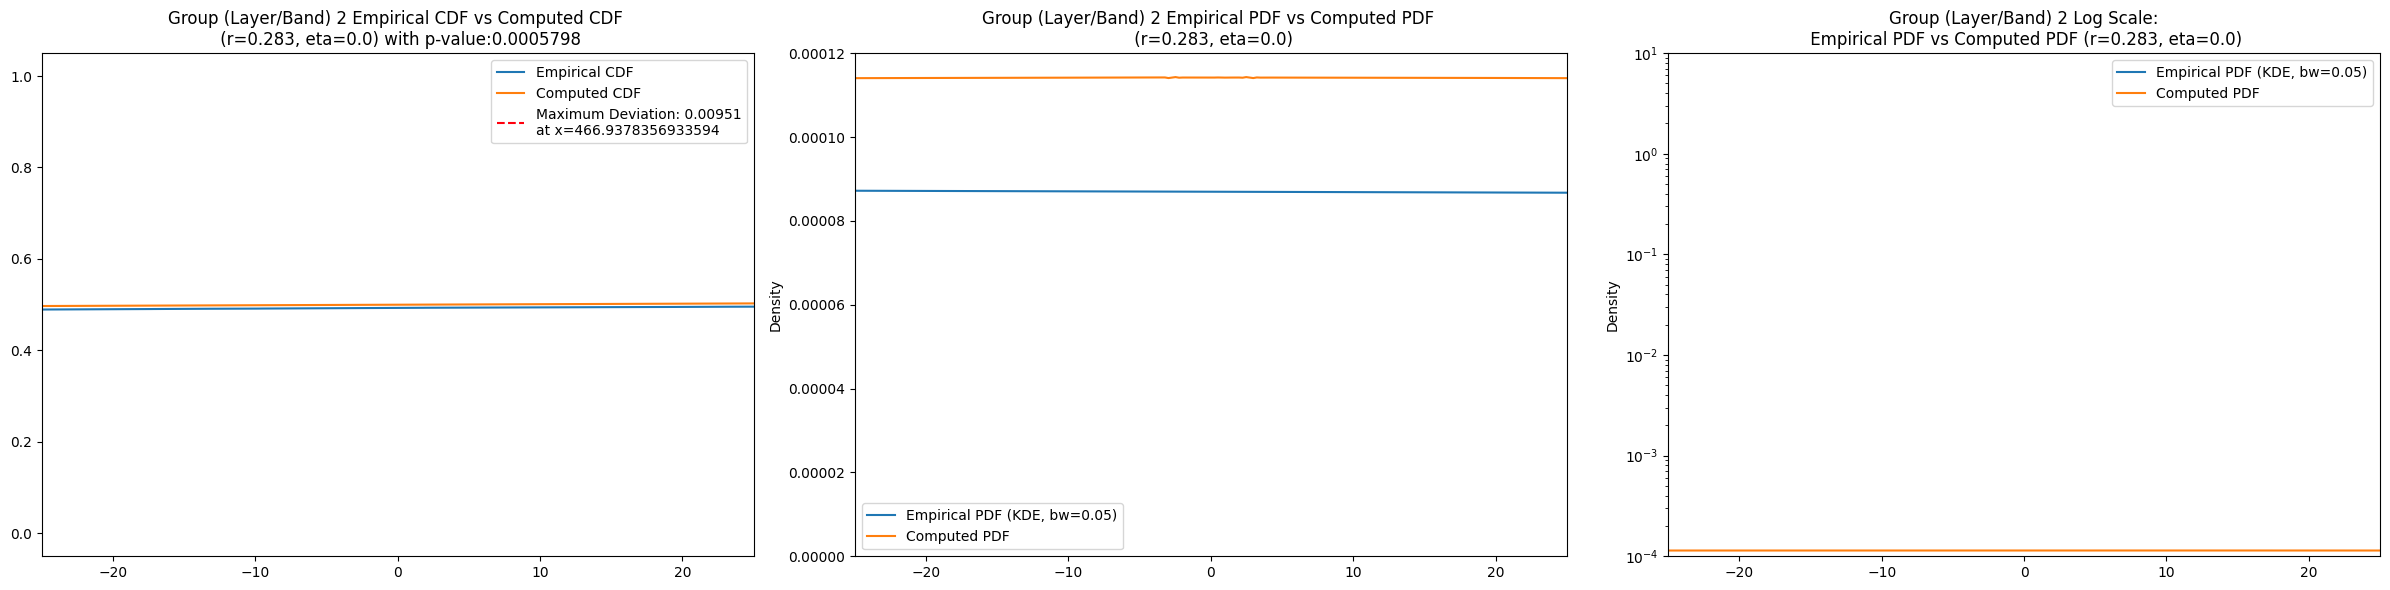

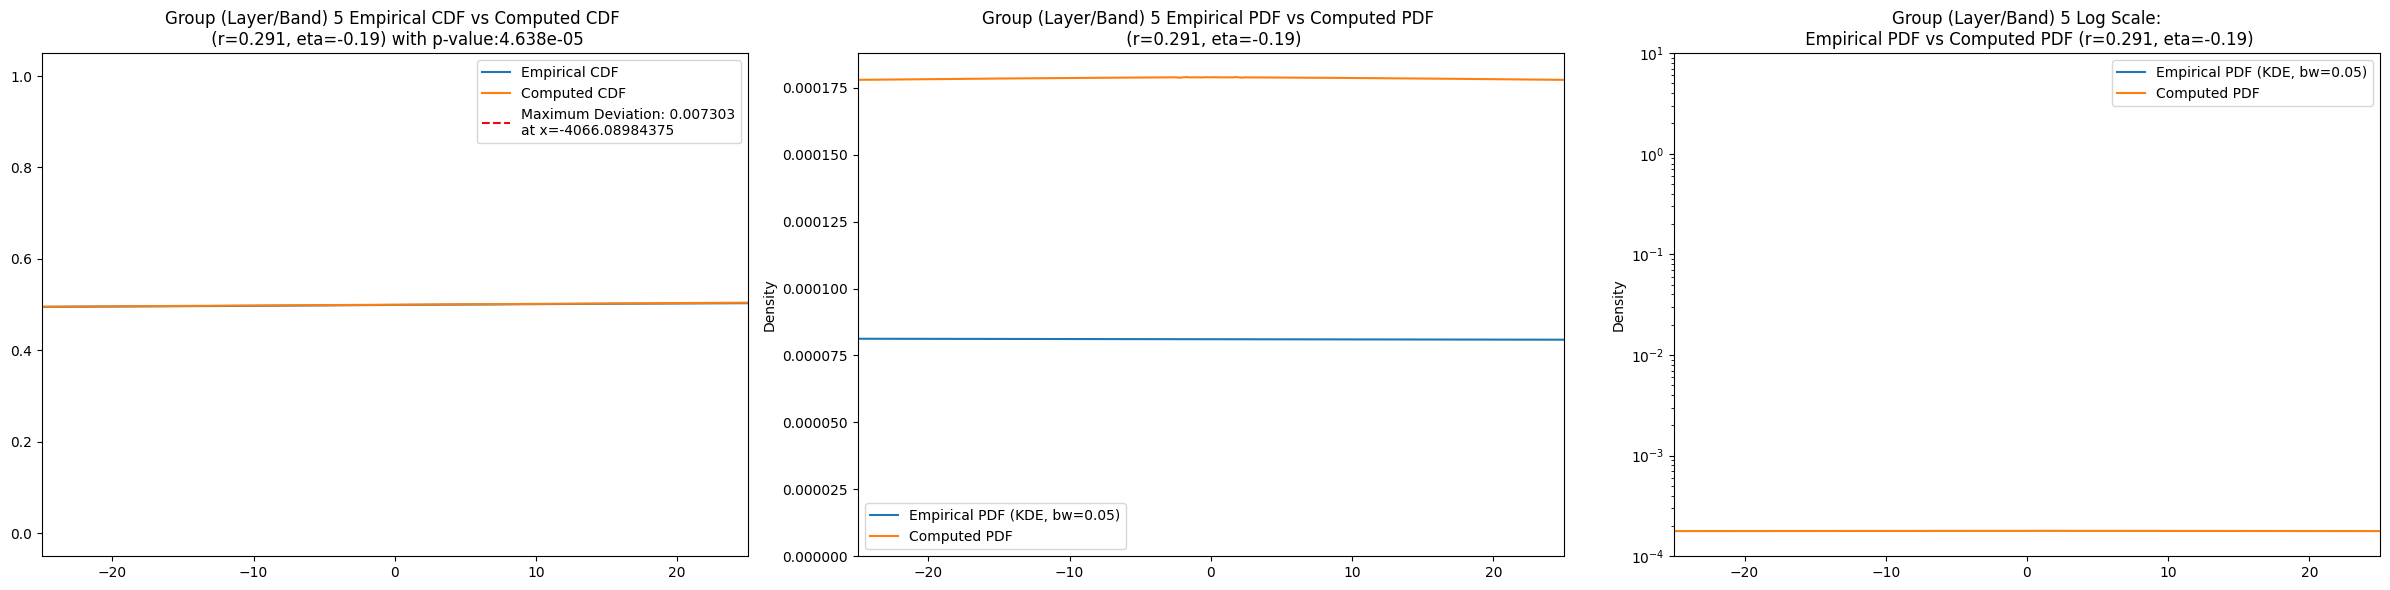

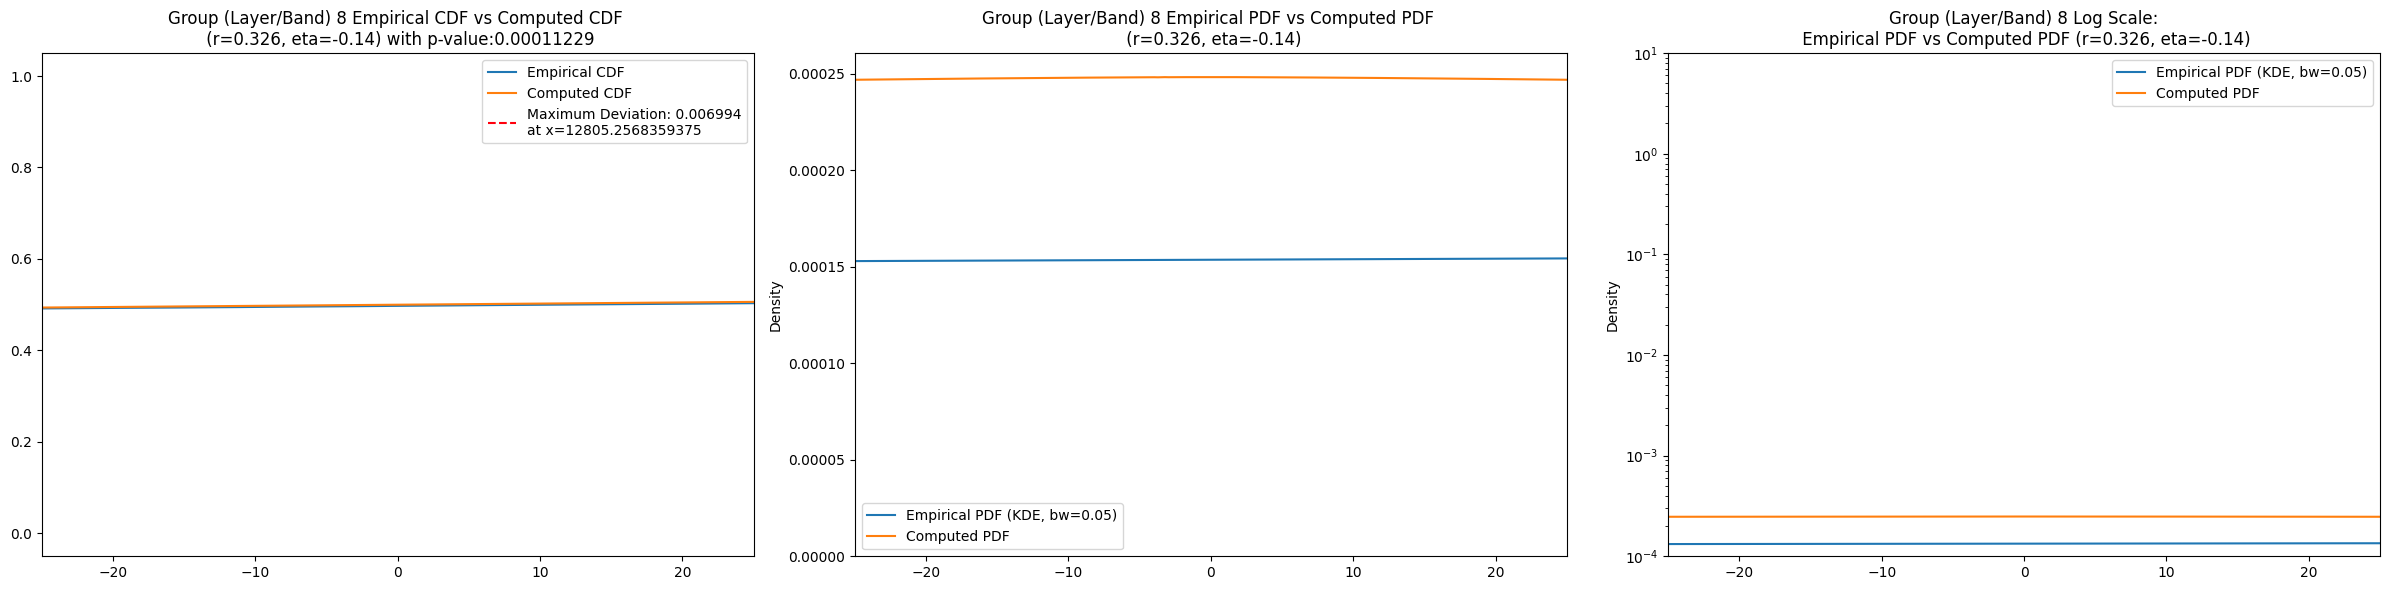

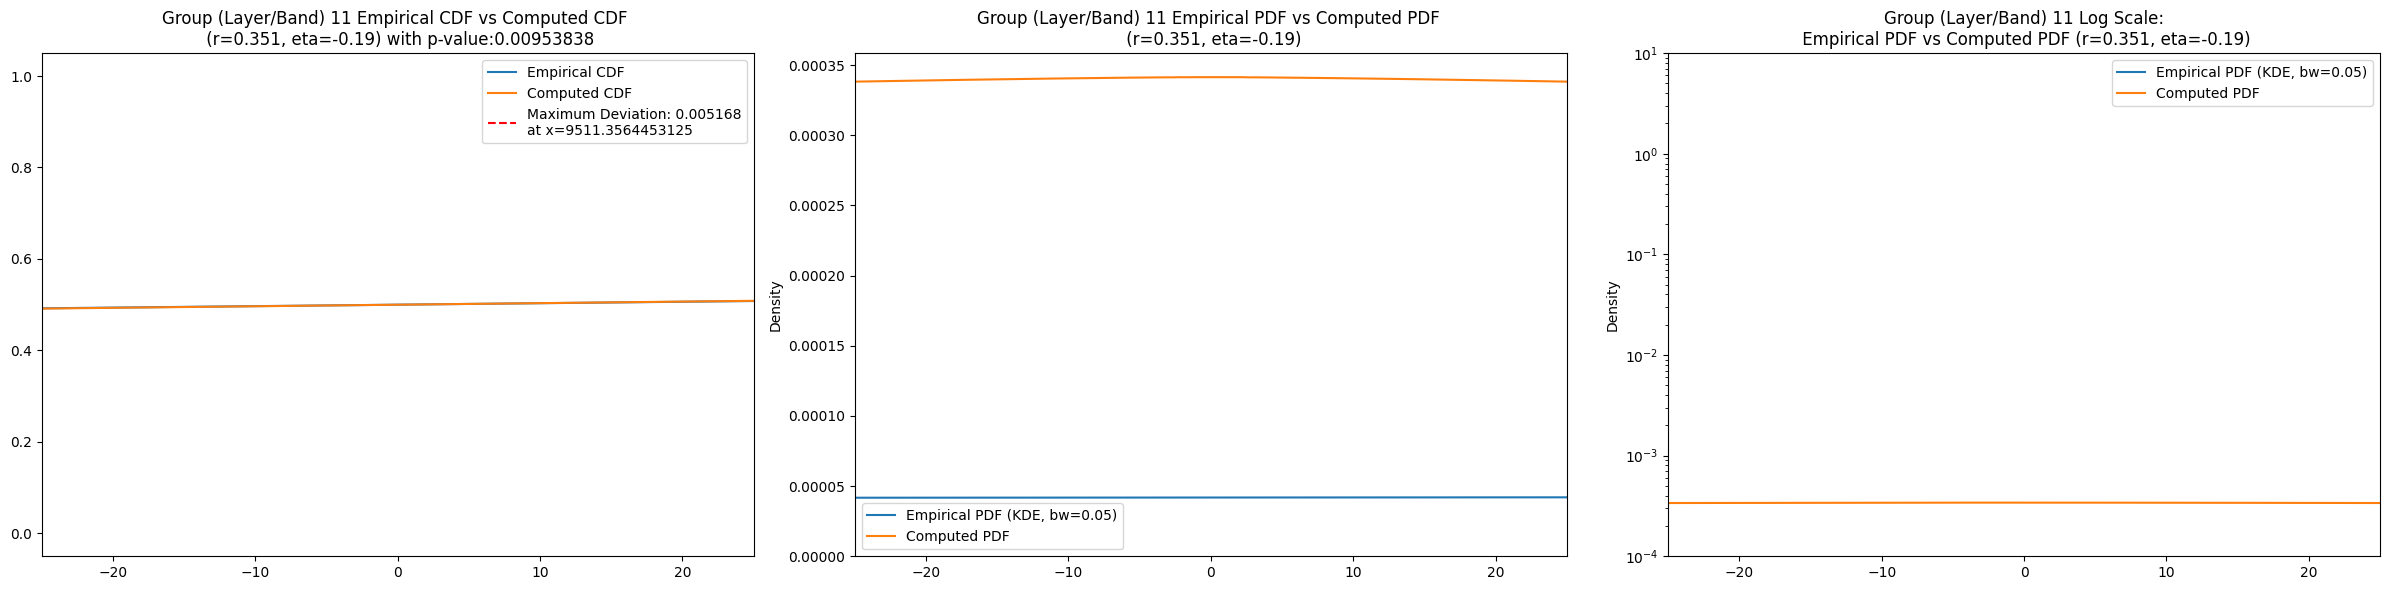

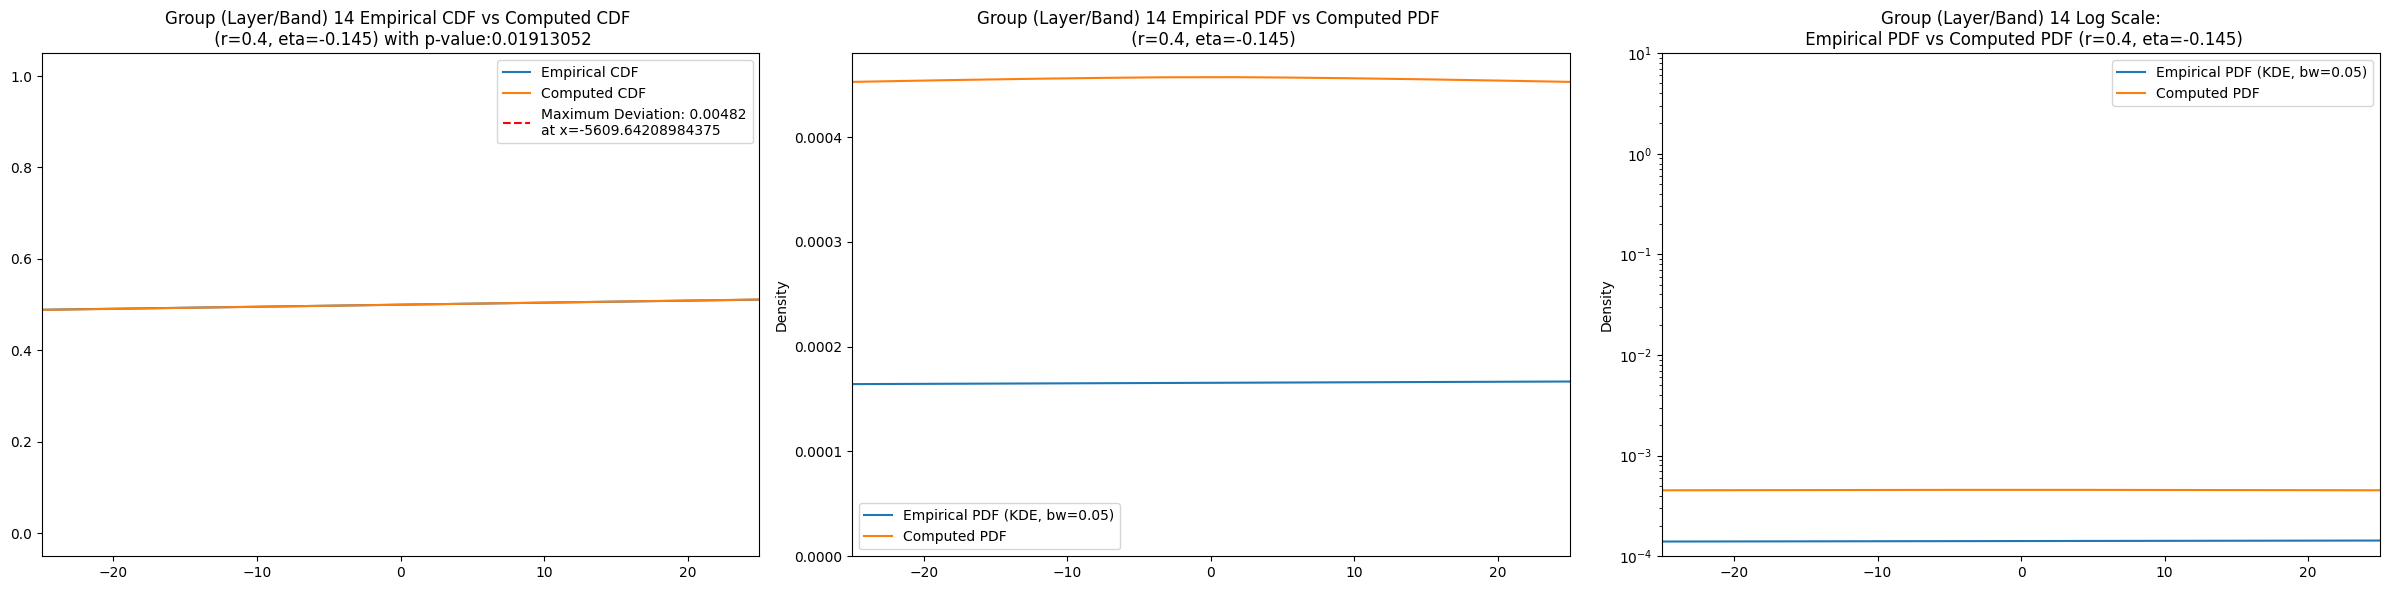

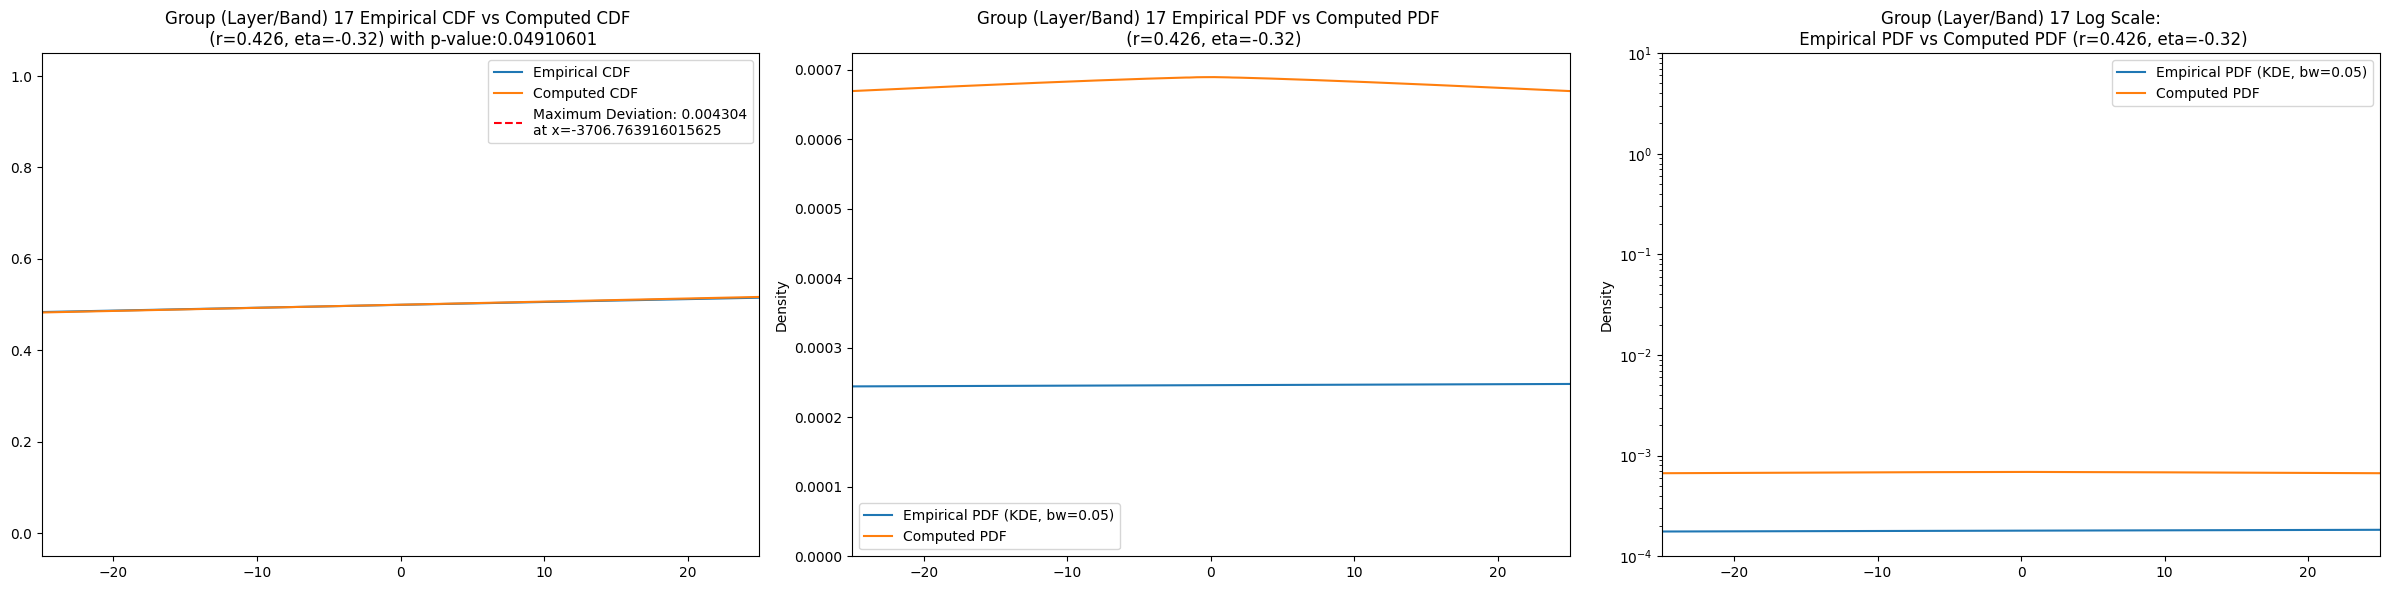

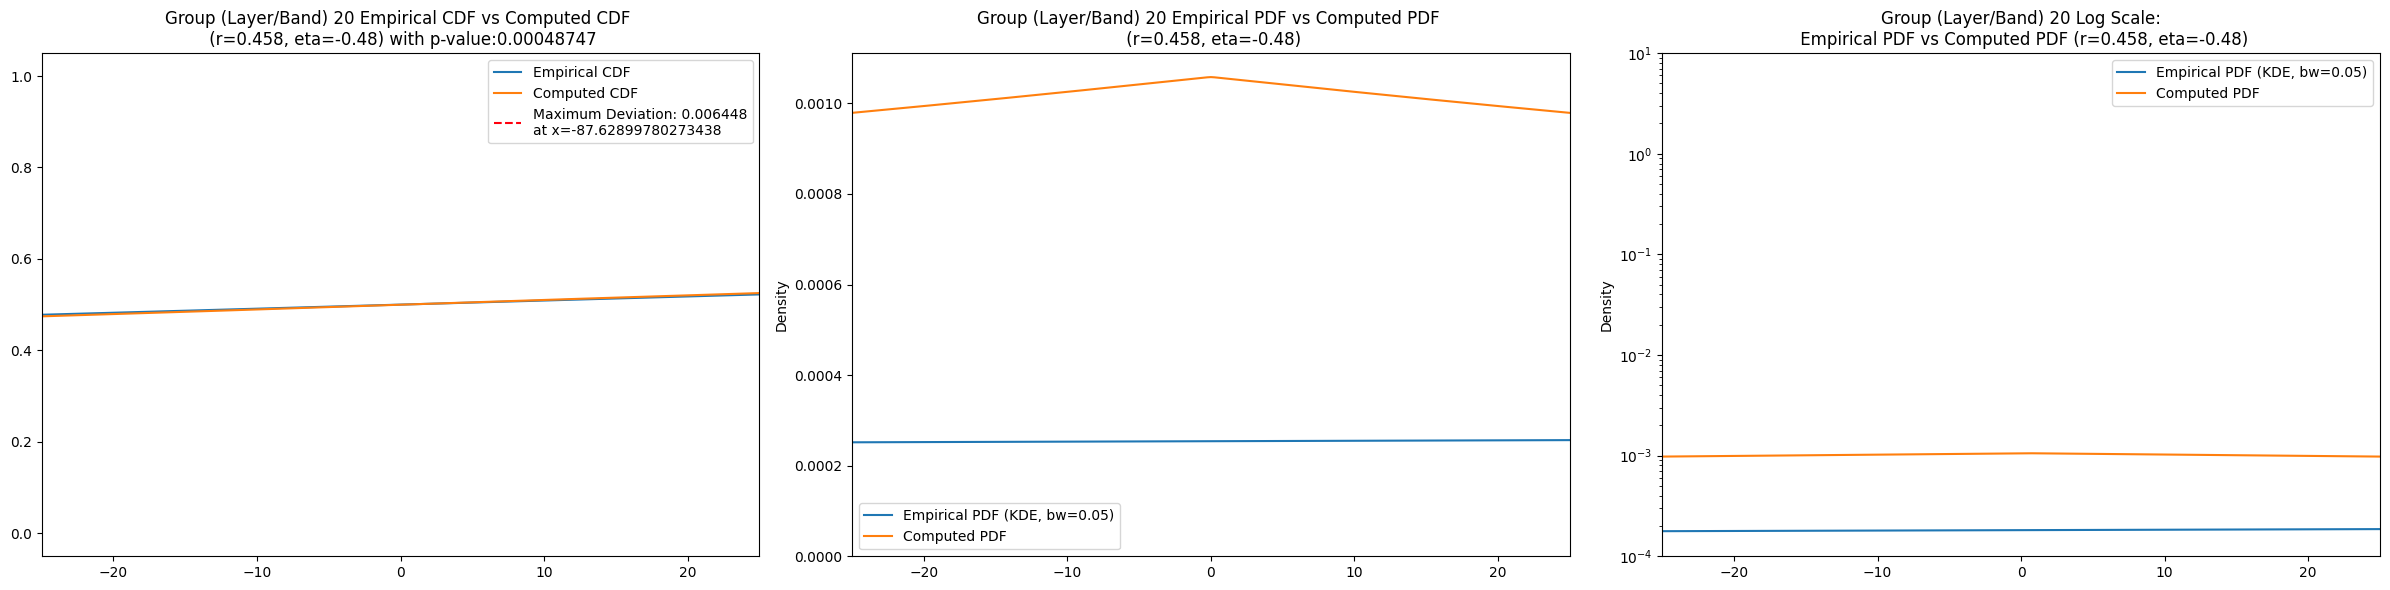

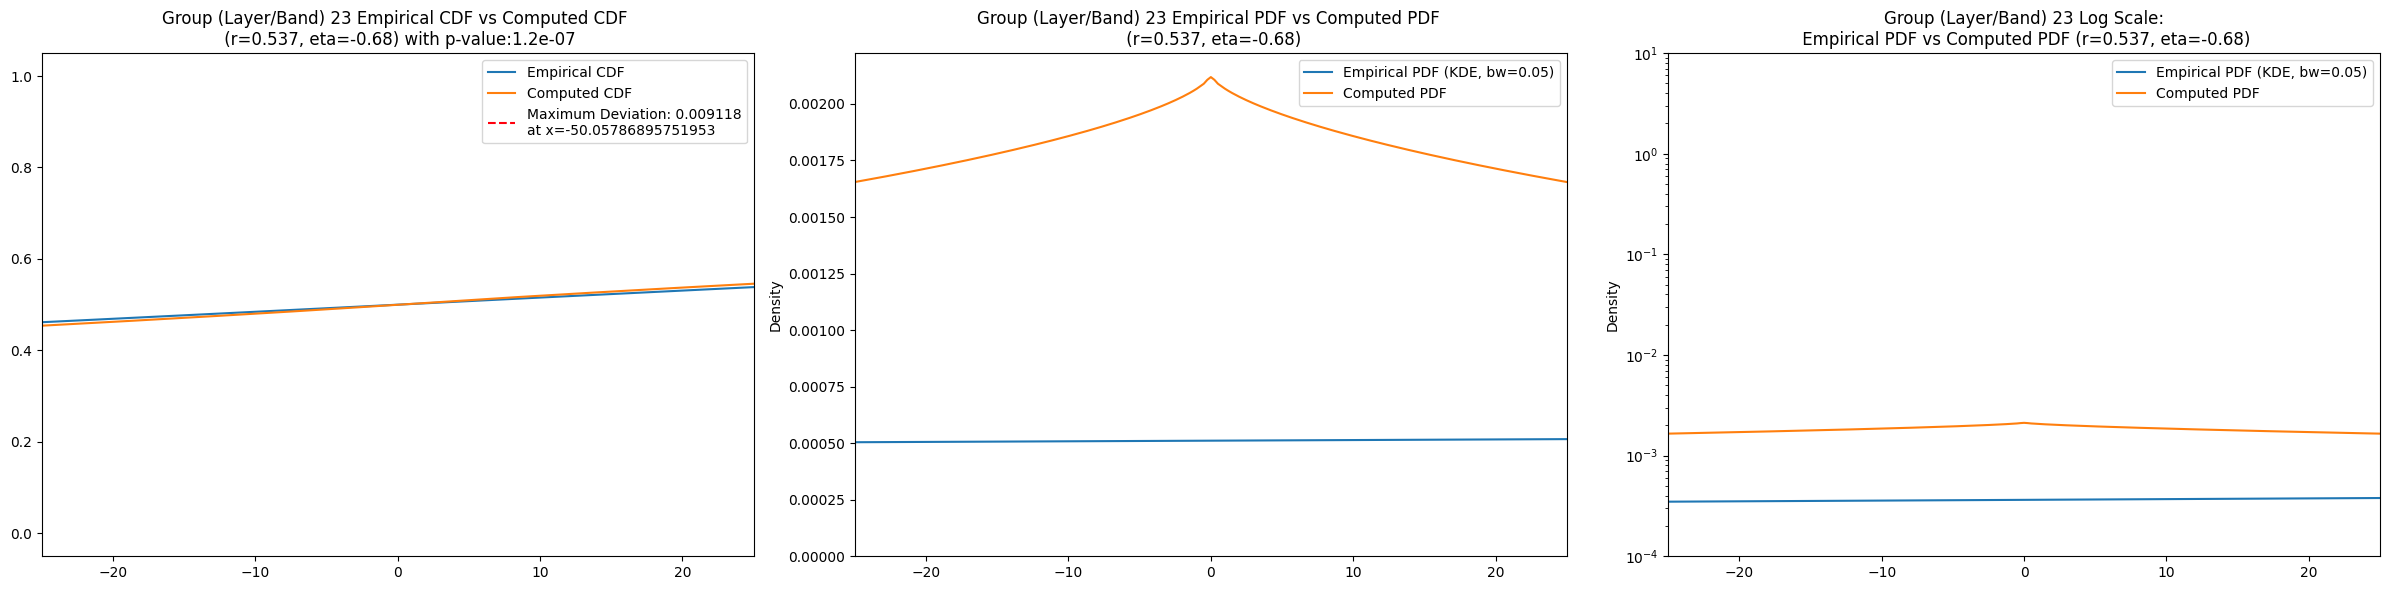

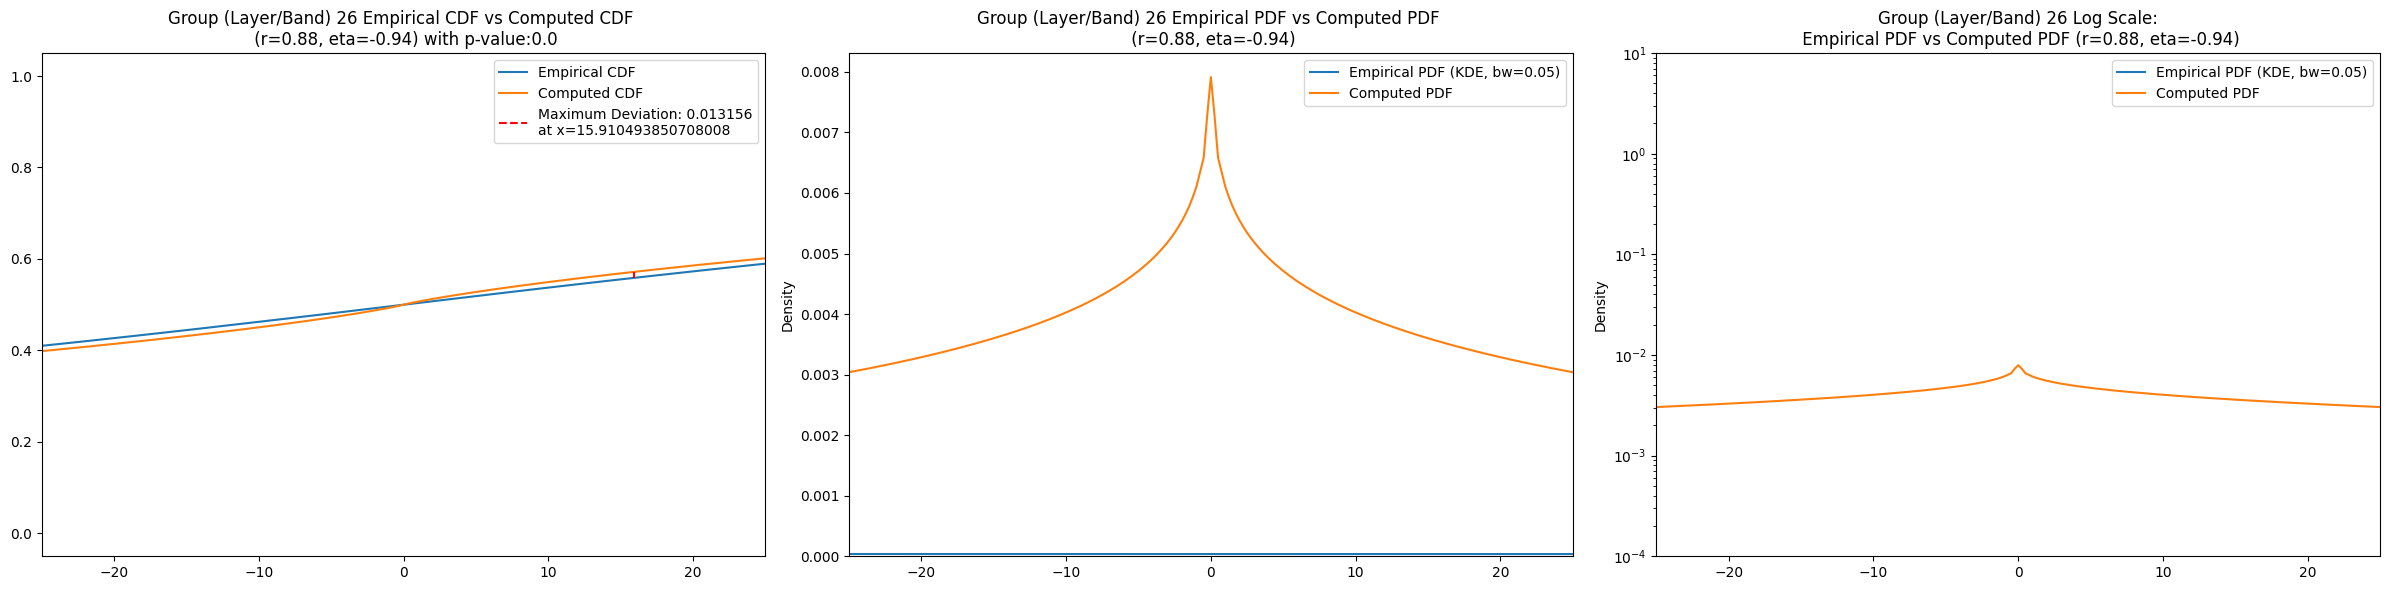

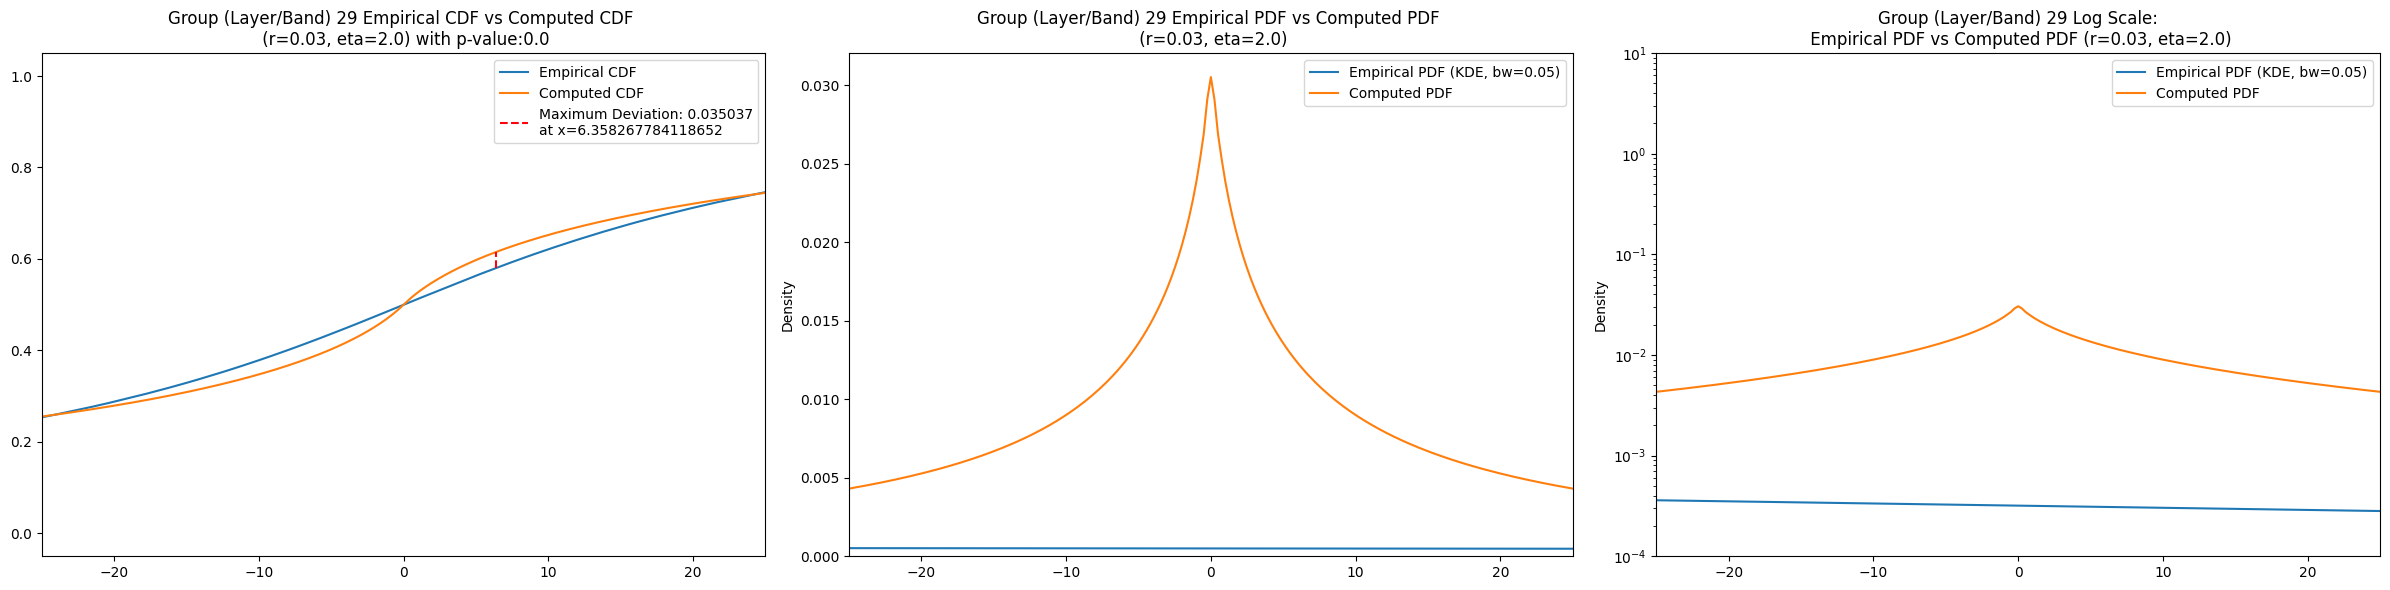

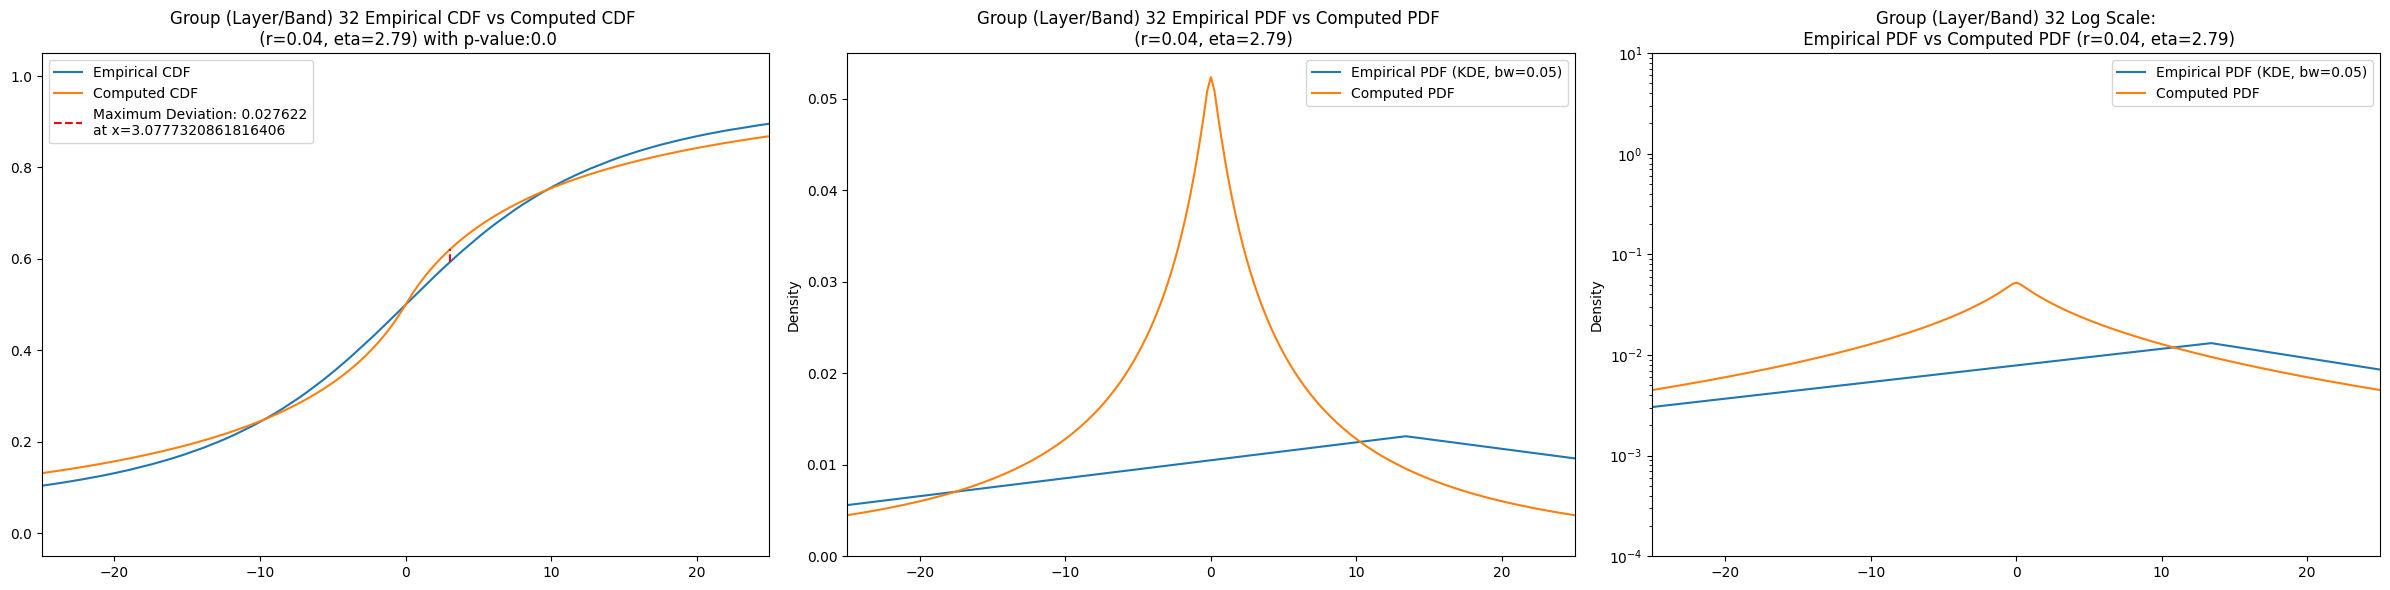

In [12]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 600)

## Comparing with Gaussian and Laplace Priors

In [13]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample / np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [14]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower     var_upper     obs_kurt  kurt_lower  \
band                                                                      
2     2.994335e+08  1.760216e+08  5.098672e+08    473.18463   99.004295   
5     1.987477e+08  9.572140e+07  7.059408e+08   2945.43360  101.462210   
8     6.328288e+07  3.516824e+07  1.386849e+08    918.95044   93.302230   
11    3.658088e+07  1.481853e+07  1.571449e+08   6517.12160   80.002920   
14    1.184948e+07  6.202577e+06  3.326602e+07   1856.47970   73.761430   
17    7.712681e+06  2.964767e+06  4.547243e+07   9698.96400   65.262900   
20    4.424362e+06  1.713362e+06  2.342466e+07   8663.62000   69.641340   
23    1.867623e+06  6.317018e+05  1.241803e+07  16824.38000   62.361816   
26    1.038924e+06  1.671769e+05  1.046601e+07  32372.20000   72.455315   
29    1.627844e+05  2.092050e+04  1.356969e+06  37523.43800   88.508550   
32    4.012389e+03  2.159656e+03  1.135524e+04   1880.42440   83.458115   

      kurt_upper  total_samples  initial_r  initial_eta  initial_scale  ...  \
band                                                                    ...   
2      1019.8701        45000.0       0.29         0.10   1.000000e+05  ...   
5      5367.8350       117000.0       0.29        -0.20   1.000000e+05  ...   
8      2766.5867       189000.0       0.33        -0.10   1.000000e+05  ...   
11     6412.9240       495000.0       0.35        -0.20   1.000000e+05  ...   
14     4089.5234      1134000.0       0.40        -0.15   1.000000e+05  ...   
17     7472.8240      2574000.0       0.43        -0.30   1.000000e+05  ...   
20     7133.9710      5967000.0       0.45        -0.50   1.000000e+05  ...   
23     8305.8750     13887000.0       0.53        -0.70   1.000000e+05  ...   
26     9320.1260     31968000.0       0.90        -0.94   1.000000e+05  ...   
29     9488.2370     73701000.0       0.03         2.00   2.970571e-66  ...   
32     4042.0374     59634000.0       0.04         2.80   4.886955e-49  ...   

      param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band                                                               
2          5561.4700              0.046405          1.197360e-84   
5          3885.5800              0.045041         1.059590e-206   
8          2579.3200              0.040807         6.612170e-274   
11         1873.4800              0.038185          0.000000e+00   
14         1298.8900              0.038303          0.000000e+00   
17          925.1350              0.039225          0.000000e+00   
20          654.5570              0.042153          0.000000e+00   
23          382.7080              0.044811          0.000000e+00   
26          168.6680              0.050555          0.000000e+00   
29           50.2810              0.057560          0.000000e+00   
32           18.1992              0.048504          0.000000e+00   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
band                                                                       
2         4952.6400             0.021000         1.140300e-17  3921.3400   
5         3450.6300             0.020023         3.543130e-41  2723.1400   
8         2298.2100             0.015836         1.333470e-41  1810.0900   
11        1663.0400             0.012965         1.044880e-72  1320.8200   
14        1146.5000             0.011968        1.671050e-141   921.1070   
17         815.6550             0.012917         0.000000e+00   655.2060   
20         577.9810             0.016380         0.000000e+00   462.1010   
23         338.9470             0.019541         0.000000e+00   269.3710   
26         150.2400             0.025412         0.000000e+00   118.1190   
29          44.9125             0.032974         0.000000e+00    35.3111   
32          16.1744             0.026145         0.000000e+00    12.9312   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.01

## Results

In [15]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [16]:
master_df

obs_var     var_lower     var_upper     obs_kurt  kurt_lower  \
band                                                                      
2     2.994335e+08  1.760216e+08  5.098672e+08    473.18463   99.004295   
5     1.987477e+08  9.572140e+07  7.059408e+08   2945.43360  101.462210   
8     6.328288e+07  3.516824e+07  1.386849e+08    918.95044   93.302230   
11    3.658088e+07  1.481853e+07  1.571449e+08   6517.12160   80.002920   
14    1.184948e+07  6.202577e+06  3.326602e+07   1856.47970   73.761430   
17    7.712681e+06  2.964767e+06  4.547243e+07   9698.96400   65.262900   
20    4.424362e+06  1.713362e+06  2.342466e+07   8663.62000   69.641340   
23    1.867623e+06  6.317018e+05  1.241803e+07  16824.38000   62.361816   
26    1.038924e+06  1.671769e+05  1.046601e+07  32372.20000   72.455315   
29    1.627844e+05  2.092050e+04  1.356969e+06  37523.43800   88.508550   
32    4.012389e+03  2.159656e+03  1.135524e+04   1880.42440   83.458115   

      kurt_upper  total_samples  initial_r  initial_eta  initial_scale  ...  \
band                                                                    ...   
2      1019.8701        45000.0       0.29         0.10   1.000000e+05  ...   
5      5367.8350       117000.0       0.29        -0.20   1.000000e+05  ...   
8      2766.5867       189000.0       0.33        -0.10   1.000000e+05  ...   
11     6412.9240       495000.0       0.35        -0.20   1.000000e+05  ...   
14     4089.5234      1134000.0       0.40        -0.15   1.000000e+05  ...   
17     7472.8240      2574000.0       0.43        -0.30   1.000000e+05  ...   
20     7133.9710      5967000.0       0.45        -0.50   1.000000e+05  ...   
23     8305.8750     13887000.0       0.53        -0.70   1.000000e+05  ...   
26     9320.1260     31968000.0       0.90        -0.94   1.000000e+05  ...   
29     9488.2370     73701000.0       0.03         2.00   2.970571e-66  ...   
32     4042.0374     59634000.0       0.04         2.80   4.886955e-49  ...   

      param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band                                                               
2          5561.4700              0.046405          1.197360e-84   
5          3885.5800              0.045041         1.059590e-206   
8          2579.3200              0.040807         6.612170e-274   
11         1873.4800              0.038185          0.000000e+00   
14         1298.8900              0.038303          0.000000e+00   
17          925.1350              0.039225          0.000000e+00   
20          654.5570              0.042153          0.000000e+00   
23          382.7080              0.044811          0.000000e+00   
26          168.6680              0.050555          0.000000e+00   
29           50.2810              0.057560          0.000000e+00   
32           18.1992              0.048504          0.000000e+00   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
band                                                                       
2         4952.6400             0.021000         1.140300e-17  3921.3400   
5         3450.6300             0.020023         3.543130e-41  2723.1400   
8         2298.2100             0.015836         1.333470e-41  1810.0900   
11        1663.0400             0.012965         1.044880e-72  1320.8200   
14        1146.5000             0.011968        1.671050e-141   921.1070   
17         815.6550             0.012917         0.000000e+00   655.2060   
20         577.9810             0.016380         0.000000e+00   462.1010   
23         338.9470             0.019541         0.000000e+00   269.3710   
26         150.2400             0.025412         0.000000e+00   118.1190   
29          44.9125             0.032974         0.000000e+00    35.3111   
32          16.1744             0.026145         0.000000e+00    12.9312   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.01

In [17]:
eng.quit()
remove_directory(os.path.join(CWD, "groupCDFs"))

PermissionError: [WinError 5] Access is denied: 'c:\\Users\\riyap\\OneDrive\\Documents\\GitHub\\hierarchical-bayesian-model-validation\\results\\case-studies\\agriVision\\fourier\\approx1e5\\green\\groupCDFs\\band11'